# Linear Regression

## Introduction

In this notebook we will look at Simple Linear Regression, Multiple Linear Regression and Polynomial Regression as part of which we will touch upon the concepts of Under and Overfitting and Regularisation. For the most part we will either use the Normal Equations in our analysis. However the normal equations become unwieldy with large amounts of data, so we will also touch upon numerical optimisation and Gradient Descent in particular.

The notebook will close with a brief case study in which we apply some of these techqniues to a real-world data set.

On the coding side we will use Python, Numpy, Pandas and Scikit-Learn together with Scipy for some manual optimisations. And we will code up some of the simpler algorithms and then compare the results with those of Scikit-Learn's implementation. Please note that the code is written to be transparent rather than elegant or efficient!


This notebook covers much of the same content as the accompanying **Linear Regression** and **Polynomial Regression** lectures, but in a format which is meant to be more interactive.

## Imports & Formatting

Please do not change the cell below, where you will see a number of imports. All of these packages are relevant for the notebook and it is important that you get used to them. 
You can find more information in their respective documentations.

In [54]:
#Standard Python libraries for data and visualisation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as sk
import scipy as sp
import ipywidgets as widgets

#Import plotting tools from matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

#Import models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Import error metric
from sklearn.metrics import mean_squared_error

#Import a dataset
from sklearn.datasets import load_diabetes

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

#Import optimiser from scipy
from scipy.optimize import minimize

#Import interat from ipywidgets
from ipywidgets import interact

In [55]:
#Check library compatibilities
from platform import python_version

python_tested = '3.11.5'
np_tested = '1.24.3'
pd_tested = '2.0.3'
mpl_tested = '3.7.2'
sk_tested = '1.3.0'
sp_tested = '1.11.1'
widgets_tested = '8.0.4'

print('Version compatiility checks: \n')

if python_tested != python_version():
    print('Python version DISCREPANCY: Running ' + python_version() + '. Expected ' + python_tested)
else:
    print('Python version compatible: Running ' + python_version())
if np_tested != np.__version__:
    print('Numpy version DISCREPANCY: Running ' + np.__version__ + '. Expected ' + np_tested)
else:
    print('Numpy version compatible: Running ' + np.__version__)
if pd_tested != pd.__version__:
    print('Pandas version DISCREPANCY: Running ' + pd.__version__ + '. Expected ' + pd_tested)
else:
    print('Pandas version compatible: Running ' + pd.__version__)
if mpl_tested != mpl.__version__:
    print('Matplotlib version DISCREPANCY: Running ' + mpl.__version__ + '. Expected ' + mpl_tested)
else:
    print('Matplotlib version compatible: Running ' + mpl.__version__)
if sk_tested != sk.__version__:
    print('Sklearn version DISCREPANCY: Running ' + sk.__version__ + '. Expected ' + sk_tested)
else:
    print('Sklearn version compatible: Running ' + sk.__version__)
if sp_tested != sp.__version__:
    print('Scipy version DISCREPANCY: Running ' + sp.__version__ + '. Expected ' + sp_tested)
else:
    print('Scipy version compatible: Running ' + sp.__version__)
if widgets_tested != widgets.__version__:
    print('Ipywidgets version DISCREPANCY: Running ' + widgets.__version__ + '. Expected ' + widgets_tested)
else:
    print('Ipywidgets version compatible: Running ' + widgets.__version__)

Version compatiility checks: 

Python version compatible: Running 3.11.5
Numpy version compatible: Running 1.24.3
Pandas version compatible: Running 2.0.3
Matplotlib version compatible: Running 3.7.2
Sklearn version compatible: Running 1.3.0
Scipy version compatible: Running 1.11.1
Ipywidgets version compatible: Running 8.0.4


Please save the attached `.css` file as `styles/custom.css`, and run the following cell in order to retain notebook formatting.

In [56]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

Please run the cell below if you wish to collapse code segments and improve readability of the notebook. 

If, after this, you wish to display all code segments again click on the cell below, then click on the menu at the top of the notebook, select the `Cell` menu, then select `Current Outputs` and select `Clear`.

In [ ]:
%%html
<style>
div.input {
    display:none;
}
</style>

## Contents

[**1. Simple Linear Regression**](#section_SimpleLinearRegression)

[**2. Multiple Linear Regression**](#section_MultiLinearRegression)

[**3. Gradient Descent**](#section_GradientDescent)

[**4. Polynomial Regression**](#section_PolyRegression)

[**5. Regularisation**](#section_Regularisation)

<a id='section_SimpleLinearRegression'></a>
## 1. Simple Linear Regression

In **Simple Linear Regression** we seek to learn a **linear mapping**, $f_{\mathbf{w}}$, between a **single** attribute, $x \in \mathbb{R}$ and a single output. $y \in \mathbb{R}$. 

$f_{\mathbf{w}}$ is characterised by a **weight vector**, $\mathbf{w} =[w_0, w_1]^T \in \mathbb{R}^2$, where $w_0$ denotes a **bias** term, so that:
\begin{equation*}
    f_{\mathbf{w}}(\mathbf{x})= w_0 + w_1 x
\end{equation*}

If we introduce an augmented attribute vector, $\mathbf{x} = [1, x]^T$, then we can express this more compactly as:
\begin{equation*}
    f_{\mathbf{w}}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}.
\end{equation*}

Of course, we will learn the parameterisation of $\mathbf{w}$ in the context of some training data:

### Training Data

Let's begin by generating some toy data which is based on a linear relationship between $x$ and $y$, corrupted by Gaussian noise.

We will denote the $n$ training examples by $\mathcal{S} = \{(x^{(i)}, y^{(i)}) \}_{i=1}^n$.

We store our input attribute data in a **design matrix**, $\mathbf{X}$:
\begin{equation*}
    \mathbf{X} = \begin{bmatrix}
1,   x^{(1)}  \\
1,   x^{(2)}  \\
\vdots \\
1,   x^{(n)}  \\
\end{bmatrix}
\end{equation*}
Where the leading ones will allow us accommodate the bias term more compactly.

And we store our output training data in a vector, $\mathbf{y}$:
\begin{equation*}
    \mathbf{y} = \begin{bmatrix}
y^{(1)}  \\
y^{(2)}  \\
\vdots \\
y^{(n)}  \\
\end{bmatrix}
\end{equation*}

<IPython.core.display.Javascript object>


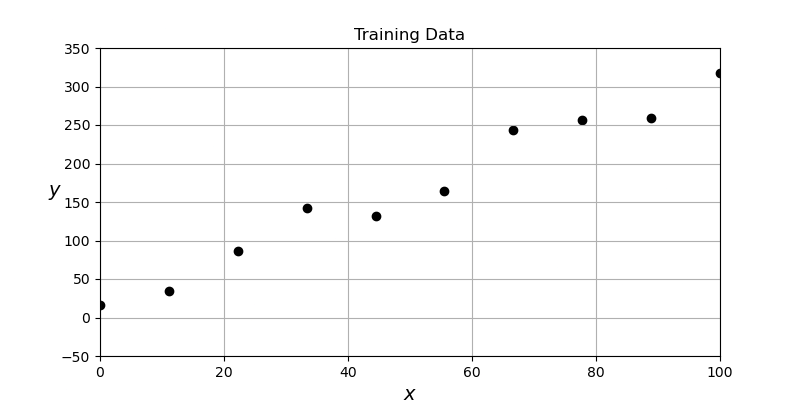

In [57]:
#Generate one-dimensional data with a bit of noise
np.random.seed(42)
num_points = 10
x_train = np.linspace(0,100,num_points).reshape(num_points,1)
y_train = 4 + 3 * x_train + 25*np.random.randn(num_points, 1)

#Plot the data
#We will be re-using the plotting figure layout, so let's make a function to do this to avoid clutter later.
def make_layout():
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14, rotation = 0)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.set_ylim(-50, 350)
    return fig,ax
    
fig, ax = make_layout()
ax.scatter(x_train,y_train, color='black')
ax.set_title('Training Data', fontsize=12)

plt.show()

### OLS using the Normal Equations

There are a variety of approaches to linear regression, characterised by a variety of different loss functions that we might seek to minimise. In **Ordinary Least Squares** (OLS) we seek to learn $\mathbf{w}$ by minimising the (scaled, mean) squared error loss evaluated over the training set:
\begin{align*}
   \mathsf{L} &= \frac{1}{2n}\sum_{i=1}^n \left( y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \right)^2 \\
   &= \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w} \Vert_2^2
\end{align*}

Since this function is continuous and differentiable in $\mathbf{w}$ then let's try to optimise it using calculus.

First we derive the gradient:
\begin{equation*}
    \nabla_{\mathbf{w}} \mathsf{L} = \frac{1}{2n} \left( \mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T \mathbf{y} \right)
\end{equation*}

Then we seek stationary points:
\begin{align*}
    \mathbf{X}^T \mathbf{X} \mathbf{w}_\mathsf{OLS} - \mathbf{X}^T \mathbf{y} &= \mathbf{0} \\
    \mathbf{X}^T \mathbf{X} \mathbf{w}_\mathsf{OLS} &= \mathbf{X}^T \mathbf{y} 
\end{align*}

And if $\mathbf{X}^T \mathbf{X}$ is invertible then we can derive the **normal equations**:
\begin{equation*}
    \mathbf{w}_\mathsf{OLS} = (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T \mathbf{y} 
\end{equation*}

We'll take a look at alternatives to this analytic approach, and what to do when $\mathbf{X}^T \mathbf{X}$ is not invertible, in the section on [**Gradient Descent**](#section_GradientDescent) later.

<div class=question>
<b>Exercise:</b>

Write a function, `LinearRegression_OLS_NE` to calculate $\mathbf{w}_\mathsf{OLS}$ using the normal equations:

1. First create a design matrix, `X` - i.e. a numpy array of shape (10,2) - by prepending a vector of ones onto the input attribute data, `x_train`, in order to handle the bias term compactly.

2. Then use the numpy `inv` and `dot` functions to solve the normal equations.

(In this particular case the output, `w_OLS`, will be a numpy array of shape (2,1), but try to write your function so that it can handle any input attribute dimensionality). 

</div>

In [58]:
def LinearRegression_OLS_NE(x_train, y_train):
    
    # Ex1:
    X = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    
    # Ex2:
    w_OLS = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_train)

    return w_OLS

Now we will use $\mathbf{w}_\mathsf{OLS}$ to generate a set of linear predictions, `y_pred`, of the outputs associated with the input attribute data, `x_train`:

<div class=question>
<b>Exercise:</b>
    
1. Write a function, `pred`, which makes predictions, `y_pred`, given a test attribute vector, `x_test`, and a weight vector, `w`.

2. Apply `LinearRegression_OLS_NE` to the training data, `x_train`, `y_train`, in order to generate `w_OLS_NE`.

3. Generate a set of predictions, `y_OLS_NE`, based on the input attribute data, `x_train`.

4. Calculate the mean squared error loss of your predictions, `mse_OLS_NE`. Do this manually using numpy's `linalg.norm` function.

5. Using this set of predictions plot the function we have just learned, together with the original data.

</div>

<IPython.core.display.Javascript object>


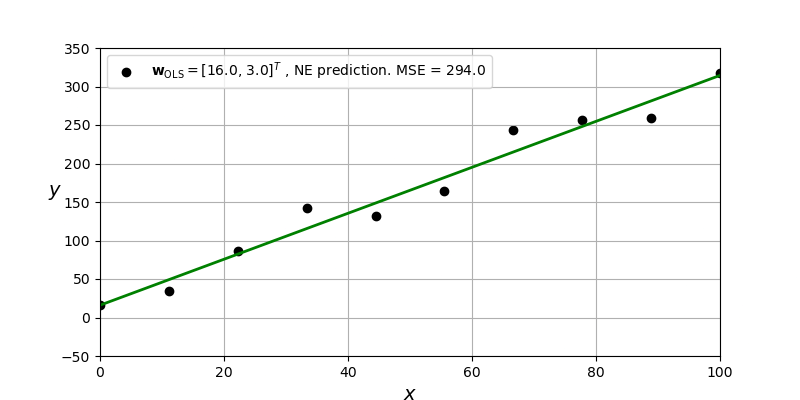

In [59]:
# Ex1:
def pred(w, x_test):
    y_pred = w[0]+np.dot(x_test,w[1:])
    return y_pred

# Ex2:
w_OLS_NE = LinearRegression_OLS_NE(x_train, y_train)

# Ex3:
y_OLS_NE = pred(w_OLS_NE, x_train)

# Ex4:
mse_OLS_NE = (np.linalg.norm((y_OLS_NE - y_train).reshape(-1,1))**2)/len(y_train)

# Ex5:
fig, ax = make_layout()
ax.scatter(x_train,y_train, color='black')

ax.plot(x_train,y_OLS_NE, color='green',linewidth=2.0)
w_OLS_NE_round = w_OLS_NE.round(decimals=0).reshape(2,).tolist()
legend_w_OLS_NE = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_NE_round) +"$^T$ , NE prediction. MSE = " + str(round(mse_OLS_NE,0))

ax.legend([legend_w_OLS_NE])
plt.show()

### OLS using Scikit-learn

Of course Scikit-learn let's us do all of this without the need to write our own functions:

<div class=question>
<b>Exercise:</b>
    
1. Use Scikit-Learn's `LinearRegression` to create a linear regression model.  

2. Apply the `fit` method to the training data, `x_train`, `y_train`, in order to train your model, then generate the Scikit-Learn OLS weight vector: `w_OLS_SK`.

3. Apply the `predict` method in order to generate a set of predictions, `y_OLS_SK`, based on the input attribute data, `x_train`.

4. Apply `mean_squared_error` to calculate the mean squared error loss of your predictions, `mse_OLS_SK`.

5. Using this set of predictions plot the function we have just learned, together with the original data.

</div>

<IPython.core.display.Javascript object>


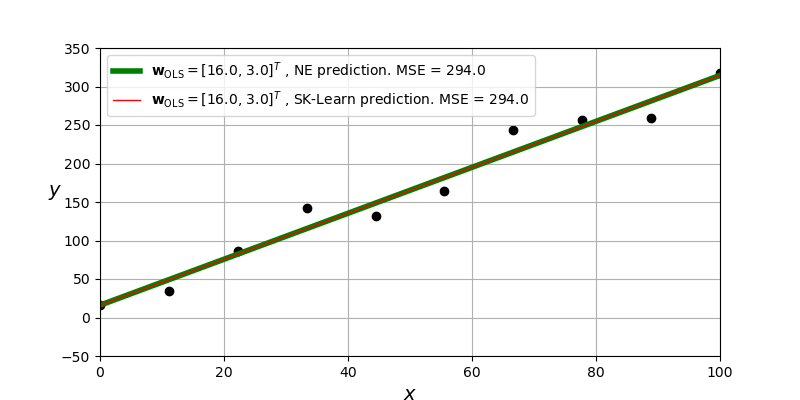

In [60]:
# Ex1:
lr = LinearRegression()

# Ex2:
lr.fit(x_train, y_train)
w_OLS_SK = np.c_[lr.intercept_,lr.coef_]

# Ex3:
y_OLS_SK = lr.predict(x_train)

# Ex4:
mse_OLS_SK = mean_squared_error(y_train, y_OLS_SK)

# Ex5:
fig, ax = make_layout()
ax.scatter(x_train,y_train, color='black')

f_w_OLS_NE, = ax.plot(x_train,y_OLS_NE, color='green',linewidth=4.0)
legend_w_OLS_NE = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_NE_round) +"$^T$ , NE prediction. MSE = " + str(round(mse_OLS_NE,0))
f_w_OLS_NE.set_label(legend_w_OLS_NE)

f_w_OLS_SK, = ax.plot(x_train,y_OLS_SK, color='red',linewidth=1.0)
w_OLS_SK_round = w_OLS_SK.round(decimals=0).reshape(2,).tolist()
legend_w_OLS_SK = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_SK_round) + "$^T$ , SK-Learn prediction. MSE = " + str(round(mse_OLS_SK,0))
f_w_OLS_SK.set_label(legend_w_OLS_SK)

ax.legend()
plt.show()

### Least Absolute Deviations

Great, Scikit-Learn will save us a lot of effort.

Now let's consider what will happen when we add an outlier to our data:

In [61]:
outlier = [5, 300]

x_train_outlier = np.vstack((x_train,outlier[0]))
y_train_outlier = np.vstack((y_train,outlier[1]))

<div class=question>
<b>Exercise:</b>
    
1. Repeat steps 1.-4. from the previous exercise, this time using the data `x_train_outlier`, `y_train_outlier`.

2. Plot the following: 
    - The original data
    - The new outlier point
    - The prediction function from the last exercise
    - The prediction function which we have just learned

</div>

<IPython.core.display.Javascript object>


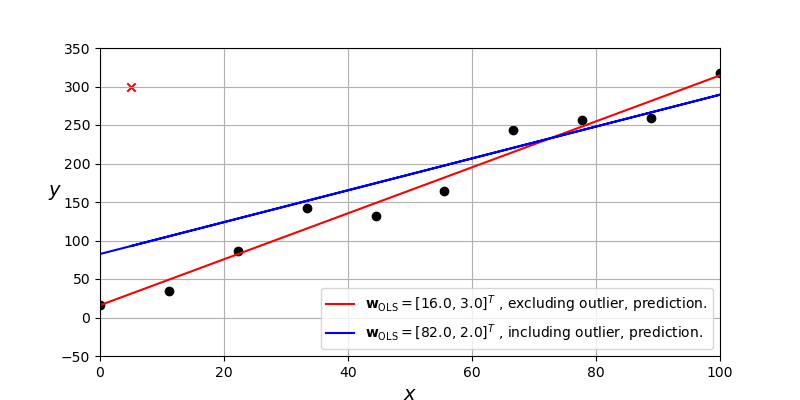

In [62]:
# Ex1:
lr_outlier = LinearRegression()
lr_outlier.fit(x_train_outlier, y_train_outlier)
w_OLS_outlier = np.c_[lr_outlier.intercept_,lr_outlier.coef_]
y_OLS_outlier = lr_outlier.predict(x_train_outlier)

# Ex2:
fig, ax = make_layout()

#Plot points
ax.scatter(x_train,y_train, color='black')
ax.scatter(outlier[0],outlier[1], color='red', marker='x')

#Plot original regression line
f_w_OLS, = ax.plot(x_train,y_OLS_SK, color='red',linewidth=1.5)
legend_w_OLS = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_SK_round) + "$^T$ , excluding outlier, prediction."
f_w_OLS.set_label(legend_w_OLS)

#Plot outlier corrupted regression line
f_w_OLS_outlier, = ax.plot(x_train_outlier,y_OLS_outlier, color='blue',linewidth=1.5)
w_OLS_outlier_round = w_OLS_outlier.round(decimals=0).reshape(2,).tolist()
legend_w_OLS_outlier = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_outlier_round) + "$^T$ , including outlier, prediction."
f_w_OLS_outlier.set_label(legend_w_OLS_outlier)

ax.legend()
plt.show()

Oh dear, OLS seems very sensitive to outliers. Let's try to remedy this issue by applying the **Least Absolute Deviations** (LAD) approach to linear regression. 

Here we seek to learn $\mathbf{w}$ by minimising the absolute error loss:
\begin{equation*}
   \mathsf{L} = \sum_{i=1}^n \vert y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \vert
\end{equation*}

The solution to this optimisation will yield $\mathbf{w}_\mathsf{LAD}$, but since this loss function isn't differentiable we'll need to resort to numerical methods instead.

Fortunately, SciPy contains an optimiser, `minimize`, which we can use for this purpose.

First we need to define the absolute error loss as a cost function:

In [63]:
def cost_function(params, X, y):
    return np.sum(np.abs(y - X.dot(params).reshape(-1,1))) #NB reshape ensures we are operating on column vectors

Then we need to create a design matrix, `X_outlier`, by prepending a vector of ones onto `x_train_outlier`:

In [64]:
X_train_outlier = np.c_[np.ones((x_train_outlier.shape[0], 1)), x_train_outlier]

And now we're ready to run `minimize` in order to yield $\mathbf{w}_\mathsf{LAD}$:

In [65]:
# Run the minimiser, with an initialisation of [0,0], since in this case w is 2-d.
output = minimize(cost_function, np.array([0,0]), args=(X_train_outlier, y_train_outlier))
print(X_train_outlier)
# Select the argmin from the outputs of 'minimize'.
w_LAD = output.x.reshape(-1,1)

[[  1.           0.        ]
 [  1.          11.11111111]
 [  1.          22.22222222]
 [  1.          33.33333333]
 [  1.          44.44444444]
 [  1.          55.55555556]
 [  1.          66.66666667]
 [  1.          77.77777778]
 [  1.          88.88888889]
 [  1.         100.        ]
 [  1.           5.        ]]


Finally, we'll generate a set of predictions based on the input attribute data using the LAD model, and plot these against the orignal OLS solution, which excluded a consideration of the outlier, and the updated OLS solutions, which included a consideration of the outlier:

<IPython.core.display.Javascript object>


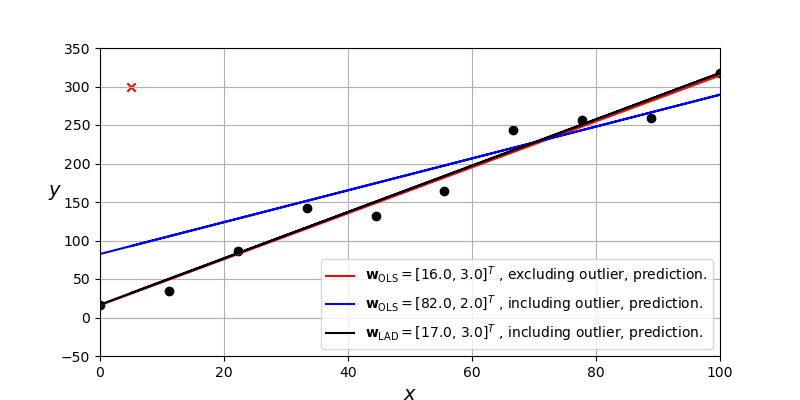

In [66]:
y_LAD_outlier = X_train_outlier.dot(w_LAD).reshape(-1,1)

fig, ax = make_layout()
#Plot points
ax.scatter(x_train,y_train, color='black')
ax.scatter(outlier[0],outlier[1], color='red', marker='x')

#Plot original regression line
f_w_OLS, = ax.plot(x_train,y_OLS_SK, color='red',linewidth=1.5)
legend_w_OLS = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_SK_round) + "$^T$ , excluding outlier, prediction."
f_w_OLS.set_label(legend_w_OLS)

#Plot outlier corrupted regression line
f_w_OLS_outlier, = ax.plot(x_train_outlier,y_OLS_outlier, color='blue',linewidth=1.5)
w_OLS_outlier_round = w_OLS_outlier.round(decimals=0).reshape(2,).tolist()
legend_w_OLS_outlier = r"$\mathbf{w}_\mathsf{OLS} = $" + str(w_OLS_outlier_round) + "$^T$ , including outlier, prediction."
f_w_OLS_outlier.set_label(legend_w_OLS_outlier)

#Plot outlier corrupted LAD regression line
f_w_LAD_outlier, = ax.plot(x_train_outlier,y_LAD_outlier, color='black',linewidth=1.5)
w_LAD_round = w_LAD.round(decimals=0).reshape(2,).tolist()
legend_w_LAD_outlier = r"$\mathbf{w}_\mathsf{LAD} = $" + str(w_LAD_round) + "$^T$ , including outlier, prediction."
f_w_LAD_outlier.set_label(legend_w_LAD_outlier)

ax.legend()
plt.show()

Great! The LAD model yields a result which looks very close to the original OLS model before our data was polluted by the outlying point. 

This is to be expected since the absolute deviation evaluation function is more **robust** to outliers than that of the squared error.

Now, let's move on to consider regression in the presence of multi-dimensional attributes:

<a id='section_MultiLinearRegression'></a>
## 2. Multiple Linear Regression

The **Multiple Linear Regression** setting is similar to that of simple linear regression, but now we seek to learn a **linear mapping**, $f_{\mathbf{w}}$, between **multiple** attributes, $\mathbf{x} = [x_1, \dots, x_m]^T \in \mathbb{R}^m$ and a single output. $y \in \mathbb{R}$. (N.B. Don't confuse multiple with **multivariate linear regression**. In multivariate linear regression we seek to predict multiple outputs).

$f_{\mathbf{w}}$ is characterised by a weight vector, $\mathbf{w} =[w_0, w_1, \dots, w_m]^T \in \mathbb{R}^{m+1}$ so that:
\begin{equation*}
    f_{\mathbf{w}}(\mathbf{x})= w_0 + w_1 x_1 + \dots + w_m x_m.
\end{equation*}
Here $w_0$ denotes a bias term as before.

As before, we can express this more compactly as $f_{\mathbf{w}}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}$.

Once again we learn in the context of training data, and we define $\mathbf{X}$ and $\mathbf{y}$ as analagous objects to those encountered in the simple setting, with obvious extensions where necessary.

Let's try to learn the OLS parameterisation of $\mathbf{w}$ using Scikit-Learn's workflow, in the context of some toy training data where $m=2$:

<IPython.core.display.Javascript object>


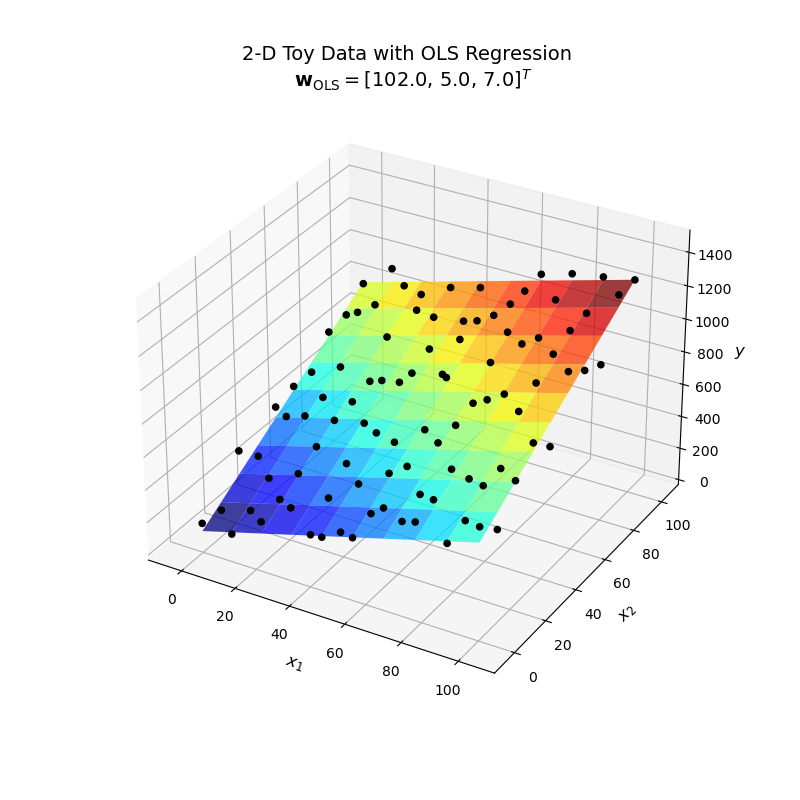

interactive(children=(IntSlider(value=10, description='num_points', max=40, min=5, step=5), IntSlider(value=10…

In [67]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection="3d")

def plot_2d_OLS(num_points, sigma):
    np.random.seed(42)
    ax.clear()

    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_zlabel('$y$', fontsize=12)
    
    ax.set_xlim(-10, 110)
    ax.set_ylim(-10, 110)
    ax.set_zlim(0, 1500)
    
    x1_train = np.linspace(0,100,num_points).reshape(num_points,1)
    x2_train = np.linspace(0,100,num_points).reshape(num_points,1)
    xx1_train, xx2_train = np.meshgrid(x1_train, x2_train)
    yy_train = (100 + 5 * xx1_train  + 7 * xx2_train) + sigma*np.random.randn(num_points, num_points)
    
    X_train = np.c_[xx1_train.ravel(), xx2_train.ravel()]
    y_train = np.c_[yy_train.ravel()]

    lr = LinearRegression(fit_intercept = True)
    lr.fit(X_train, y_train)
    
    w_OLS = np.append(lr.intercept_,lr.coef_).reshape(3,1)
    w_OLS_round = w_OLS.round(decimals=0).reshape(3,).tolist()
    y_OLS = lr.predict(X_train)

    pts = ax.scatter(xx1_train, xx2_train, yy_train, color='black', alpha=1)
    reg = ax.plot_surface(xx1_train, xx2_train, y_OLS.reshape(num_points,num_points), cmap=plt.cm.jet, alpha=0.75)

    ax.set_title('2-D Toy Data with OLS Regression \n $\mathbf{w}_\mathsf{OLS} = $' + str(w_OLS_round) + "$^T$", 
                 fontsize=14)

    plt.show()
    
int_plot = interact(plot_2d_OLS, 
                    num_points = widgets.IntSlider(value=10, min=5, max=40, step=5), 
                    sigma = widgets.IntSlider(value=100, min=0, max=300, step=25))

<div class=question>
<b>Exercise:</b>

Try adjusting the values of `num_points` and `sigma`, which control the number of points in our training data, and the corruption of the outputs of those data points by noise respectively. 

What do you observe about the OLS regression surface as these values vary?

</div>

<div class=answer>
<b>Answer:</b>

The OLS regression surface tends to the true surface as the noise decreases and as the number of training points increases.

</div>

<a id='section_GradientDescent'></a>
## 3. Gradient Descent

When we implemented OLS manually we made use of the Normal Equations. But these can only be applied if $\mathbf{X}^T \mathbf{X}$ is invertible. Furthermore as the dimensionality of the data, $m$, becomes large then these equations become unwieldy.

So what are we to do? SciKit-Learn seems to be able to handle these problematic regimes, so what is being used there? The answer is numerical optimisation, and perhaps the most commonly used such optimisation procedure in machine learning is **gradient descent**. This is a first order, iterative optimisation algorithm that takes steps in proportion to the negative of the gradient at each step in the procedure.

When applying this to OLS, in which we are seeking to learn an optimal $\mathbf{w}$, then we call the iterative setting of $\mathbf{w}$ after the $t$-th step, $\mathbf{w}_{(t)}$. 

The iterative steps are also know as **epochs**. 

We begin by initialising $\mathbf{w}_{(0)}$ somehow, often randomly, after which we update according t the following procedure:
\begin{equation*}
    \mathbf{w}_{(t+1)} \leftarrow \mathbf{w}_{(t)} - \alpha \nabla_{\mathbf{w}}\mathsf{L}\vert_{\mathbf{w}=\mathbf{w}_{(t)}}
\end{equation*}

Here $\alpha>0$ is the **learning rate** which determines the step size, while, for OLS, $\nabla_{\mathbf{w}} \mathsf{L} = \frac{1}{n} \left( \mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T \mathbf{y} \right)$.

### One-Dimensional Gradient Descent

Let's investigate the performance of gradient descent on a simple 1-dimensional data set. 

On this occasion we will restrict things somewhat so that the bias term does not have to be learned i.e. $\mathbf{x} = x$ and $\mathbf{w}=w$:

In [68]:
#Generate one-dimensional data with a bit of noise
np.random.seed(42)
num_points = 50
x_train = np.linspace(0,100,num_points).reshape(num_points,1)
y_train = 3 * x_train + 10*np.random.randn(num_points, 1)

<div class=question>
<b>Exercise:</b>

Write a function `LinearRegression_OLS_GD` with:
- Inputs: `X_train`, a design matrix; `y_train`; `w_init`, an initial setting for $\mathbf{w}_{(0)}$; `alpha`, and; `max_epoch`, which limits the number of iterations for the procedure
- Outputs: `w_hist`, an array containing $\{\mathbf{w}_{(t)}\}_{t=1}^{n}$, and; `L_hist`, an array containing $\{\mathsf{L}_{(t)}\}_{t=1}^{n}$ - the evaluation of the loss at each iteration.


1. First initialise the arrays for `L_hist` and `w_hist`.

2. Set up a loop which ends when `max_epoch` is reached, and which generates the following at each pass:


- The gradient
- The updated weight vector
- The update loss
- Augmented `L_hist` and `w_hist` arrays.

</div>

In [69]:
# Ex
def LinearRegression_OLS_GD(X_train, y_train, w_init, alpha, max_epoch=10):
    n = len(y_train)
    X = X_train
    y = y_train
    w_t = w_init

    # Ex 1
    # Initialise
    L_hist = (1/(2*n)) * (y_train - np.matmul(X,w_t)).T.dot(y_train - np.matmul(X,w_t))
    w_hist = w_t.T

    # Ex 2    
    epoch = 0
    while epoch < max_epoch: 
        grad = (1/n) * X.T.dot(X.dot(w_t) - y).reshape(np.shape(X)[1],1)
        w_t = (w_t - alpha * grad)
        loss = (1/(2*n)) * (y - X.dot(w_t)).T.dot(y - X.dot(w_t))[0][0]
        L_hist = np.vstack((L_hist, loss))
        w_hist = np.vstack((w_hist,w_t.T))
        epoch = epoch + 1
    
    return w_hist, L_hist

Now, let's run `LinearRegression_OLS_GD` with `max_epoch=20`, `alpha=0.0005`, and `w_init=[[10]]` as inputs, then illustrate the outputs with plots of:
- $\mathsf{L}_{(t)}$ v $\mathsf{w}_{(t)}$
- $\mathsf{L}_{(t)}$ v $t$
- the regression function generated by $w_{(t)}$

all animated by evolving epoch: 

In [95]:
#Run Gradient Descent on the data
max_epoch=20
alpha=0.0005
w_init = np.array([10]).reshape(np.shape(x_train)[1],1)

w_hist, L_hist = LinearRegression_OLS_GD(x_train, y_train, w_init=w_init, alpha=alpha, max_epoch=max_epoch)

<IPython.core.display.Javascript object>


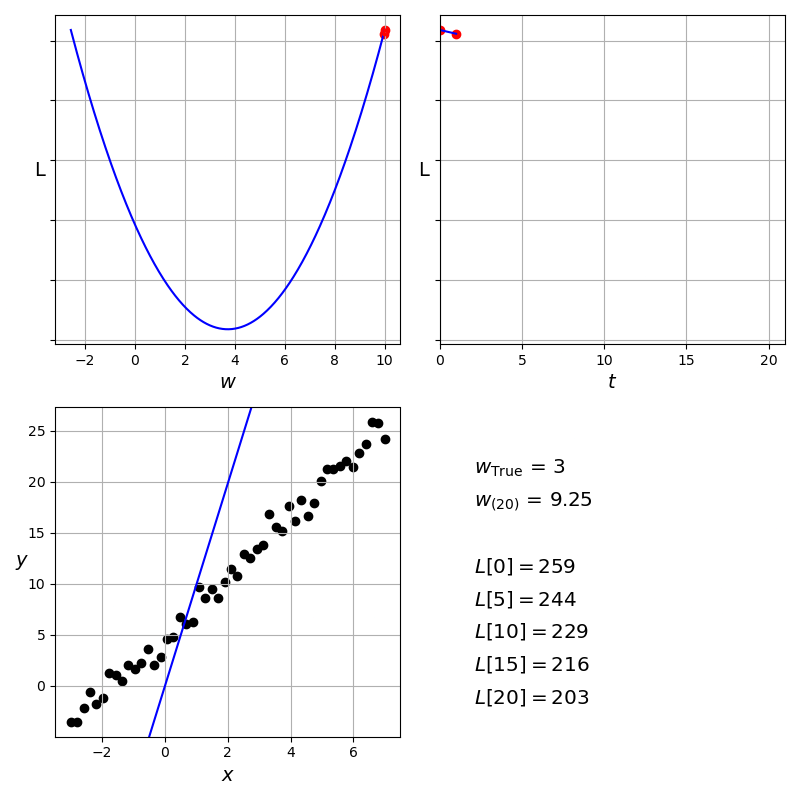

In [96]:
#Run animated plots of the outputs
#plt.close('all')
fig = plt.figure(figsize=(8,8))


#PLOT 1: L(t) v w(t)
ax1 = fig.add_subplot(2,2,1)
ax1.grid()
ax1.set_xlabel('$w$', fontsize=14)
ax1.set_ylabel('$\mathsf{L}$', fontsize=14, rotation = 0)
ax1.set_yticklabels([])
#Set w_t range
argmin_L = (np.matmul(np.linalg.inv(x_train.T.dot(x_train)),x_train.T.dot(y_train))).item()
min_wt = min(w_hist)
max_wt = max(w_hist)
range_wt = max([abs(argmin_L - min_wt), abs(max_wt - argmin_L)])
w_t = np.linspace(argmin_L - range_wt, argmin_L + range_wt, 500)
#Plot loss surface
L = []
for i in range(500):
    loss = ((1/(2*num_points)) * (y_train - x_train*w_t[i]).T.dot(y_train - x_train*w_t[i])).item()
    L.append(loss)
ax1.plot(w_t, L, color='blue')
#Placeholder for animated (w,L) points  
ax1_anim_point = ax1.scatter([], [], color='red')
#Placeholder for lines connecting animated (w,L) points  
ax1_anim_line, = ax1.plot([], [], marker='o', markersize=2, color='red')


#PLOT 2: L(t) v t
ax2 = fig.add_subplot(2,2,2)
ax2.grid()
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('$\mathsf{L}$', fontsize=14, rotation = 0)
ax2.set_yticklabels([])
#Set axis ranges
ax2.set_xlim(0, len(w_hist))
ax2.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])
#Placeholder for animated (t,L) points  
ax2_anim_point  = ax2.scatter([], [], color='red')
#Placeholder for lines connecting animated (t,L) points  
ax2_anim_line, = ax2.plot([], [], color='blue')


#PLOT 3: Regression function
ax3 = fig.add_subplot(2,2,3)
ax3.grid()
ax3.set_xlabel('$x$', fontsize=14)
ax3.set_ylabel('$y$', fontsize=14, rotation = 0)
#Plot training data
ax3.scatter(x_train, y_train, color='black')
#Placeholder for animated regression line plots
ax3_anim_line, = ax3.plot([], [], color='blue')


#PLOT 4: Print interesting numbers
ax4 = fig.add_subplot(2,2,4)
ax4.set_axis_off()
#Print w and L numbers
ax4.text(0.1,0.8,'$w_{\mathsf{True}}$ = 3', fontsize = 'x-large')
ax4.text(0.1,0.7,'$w_{(20)}$ = '+str(np.round(w_hist[-1][0],2)), fontsize = 'x-large')
space = 1
for i in [0,5,10,15,20]:
    num = np.round(L_hist[i][0],0)    
    ax4.text(0.1,0.6 - 0.1*space,'$L[$' + str(i) + '$] = $'+str("{:,}".format(int(num))), fontsize = 'x-large')
    space += 1


#ANIMATION
def animate(i=21):    
    ax1_anim_point.set_offsets(np.c_[w_hist[0:i],L_hist[0:i]])
    ax1_anim_line.set_data(w_hist[0:i], L_hist[0:i])

    ax2_anim_point.set_offsets(np.c_[np.arange(0, i, 1),L_hist[0:i]])
    ax2_anim_line.set_data(np.arange(0, len(w_hist[0:i]), 1),L_hist[0:i])
    
    ax3_anim_line.set_data(x_train,w_hist[i]*x_train)
    
    return ax1_anim_point, ax1_anim_line, ax2_anim_point, ax2_anim_line, ax3_anim_line

ani = animation.FuncAnimation(fig, animate, frames=np.arange(max_epoch+1), 
                              interval=300, blit=True, repeat_delay=100)

fig.tight_layout()
plt.show()

<div class=question>
<b>Exercise:</b>

Try changing the settings of `max_epoch` and `alpha`. What do you notice?

Can you calculate (algebraically) a lower bound on the maximum setting of `alpha` beyond which gradient descent will no longer converge?

</div>

<div class=answer>
<b>Answer:</b>

As `max_epoch` increases the algorithm converges more closely to the true solution provided `alpha` is small enough.
    
`alpha` governs step size - too small leads to slow convergence, too large leads to divergence.

Objective function at each iteration:
\begin{equation*}
    L_{\mathbf{w}_t} = \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_t \Vert_2^2
\end{equation*}

Convergence condition:
\begin{equation}
    L_{\mathbf{w}_{t+1}} - L_{\mathbf{w}_t} < 0
\end{equation}

Thus:
\begin{align}
    L_{\mathbf{w}_{t+1}} - L_{\mathbf{w}_t} &= \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_{t+1} \Vert_2^2 - \frac{1}{2} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_{t} \Vert_2^2 \\
    &= \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \left(\mathbf{w}_t - \alpha_t \mathbf{X}^T (\mathbf{X} \mathbf{w}_t - \mathbf{y}) \right)\Vert_2^2 - \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_{t} \Vert_2^2 \\
    &= \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_t + \alpha_t \mathbf{X} \mathbf{X}^T (\mathbf{X} \mathbf{w}_t - \mathbf{y}) \Vert_2^2 - \frac{1}{2n} \Vert \mathbf{y} - \mathbf{X} \mathbf{w}_{t} \Vert_2^2 \\
    &= \frac{1}{2n} \Vert \alpha \mathbf{X} \mathbf{X}^T (\mathbf{X} \mathbf{w}_t - \mathbf{y}) \Vert_2^2 + \alpha_t (\mathbf{y} - \mathbf{X}\mathbf{w}_t)^T (\mathbf{X} \mathbf{X}^T (\mathbf{X} \mathbf{w}_t - \mathbf{y})) \\
    &= \frac{1}{2n} \alpha^2 (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})^T \mathbf{X}^T\mathbf{X} (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y}) - \alpha_t \Vert \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} \Vert_2^2
\end{align}
	
Therefore, by the convergence condition:
\begin{align}
    \alpha_t (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})^T \mathbf{X}^T\mathbf{X}& (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y}) - 2n\Vert \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} \Vert_2^2 < 0\\
    \implies \qquad \alpha_t &< 2n \frac{\Vert \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} \Vert_2^2}{ (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})^T \mathbf{X}^T\mathbf{X} (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})} \\
    &< 2n \frac{\Vert \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} \Vert_2^2}{ \Vert \mathbf{X} (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})\Vert_2^2}
\end{align}

If $(m=1)$ then $(\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})$ has the dimensions of a scalar.
	
Therefore, in this case we can write the conditions as:
\begin{align}
    \alpha_t &< 2n \frac{\Vert \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} \Vert_2^2}{ (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})^T \mathbf{X}^T\mathbf{X} (\mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y})} \\
    &= 2n \frac{( \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} )^2}{ \mathbf{X}^T\mathbf{X} ( \mathbf{X}^T \mathbf{X} \mathbf{w}_t - \mathbf{X}^T \mathbf{y} )^2} \\
    &= \frac{2n}{\mathbf{X}^T\mathbf{X}}
\end{align}

And this condition is independent of epoch.

</div>

In [102]:
lb = 2*num_points/np.matmul(np.transpose(x_train),x_train)[0][0]
print('Lower bound on max setting of alpha =' + str(lb))

Lower bound on max setting of alpha =0.1578099838969404


### Data Scaling

Now let's consider the effects of data scaling. 

These become apparent when we are effecting gradient descent in more than one dimension so let's extend our previous analysis so that now we have to learn the bias term as well as the slope for our linear regression, i.e. $\mathbf{x} = [1,x_1 ]^T$ and $\mathbf{w}= [w_0 , w_1 ]^T$

- First we'll generate some new toy data.
- Then we'll create a design matrix with a column of pre-pended 1's in order to capture the fact that we'll be learning a bias term this time.
- Next we'll set some parameters to be used when we run `LinearRegression_OLS_GD`. In particular, well set `max_epoch=20`, `alpha=0.15`, and `w_init=[[10,10]]` as inputs, before running the procedure to generate `w_hist` and `L_hist`.
- Finally we'll illustrate the outputs with similar plots to the ones we used in one dimension earlier. However this time the first plot will illustrate the loss using a contour plot which evaluates the loss at different settings of $w_0$ and $w_1$:

In [98]:
#Generate one-dimensional data with a bit of noise
np.random.seed(42)
num_points = 50
x_train = np.linspace(-3,7,num_points).reshape(num_points,1)
y_train = 5 + 3 * x_train + 1*np.random.randn(num_points, 1)

In [99]:
#Create design matrix
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]

#Set some parameters to be used in the following experiments
max_epoch_global =20
alpha_global =0.15
w_init_global = np.array([10,10]).reshape(np.shape(X_train)[1],1)

#Set parameters to be used in this experiment
max_epoch = max_epoch_global
alpha = alpha_global
w_init = w_init_global

#Run Gradient Descent on the data
w_hist, L_hist = LinearRegression_OLS_GD(X_train, y_train, w_init=w_init, alpha=alpha, max_epoch=max_epoch)

<IPython.core.display.Javascript object>


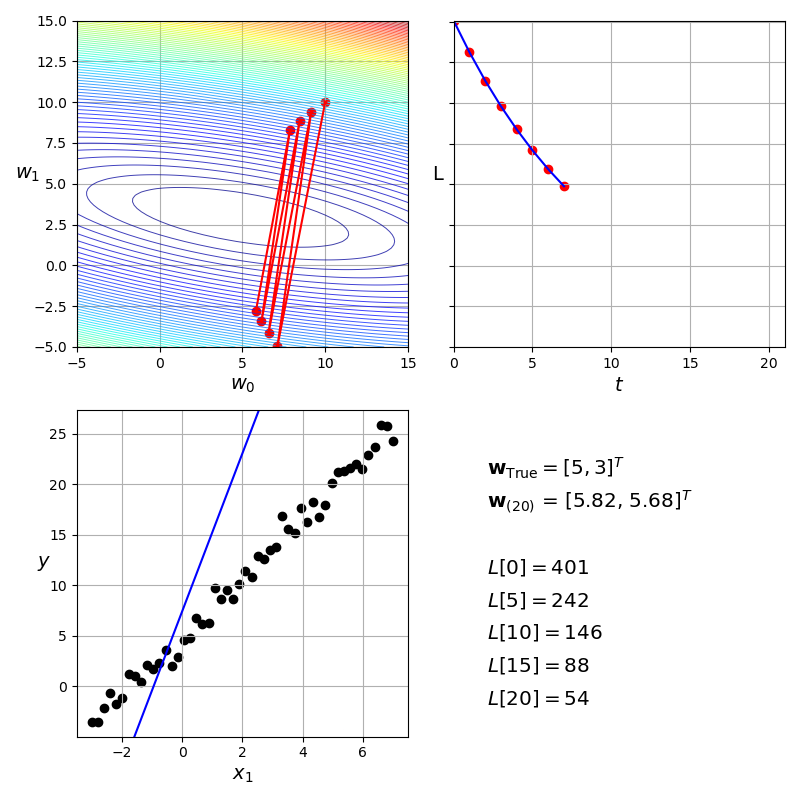

In [100]:
#Run animated plots of the outputs
#plt.close('all')
fig = plt.figure(figsize=(8,8))


#PLOT 1: contour plot of L(t) v w_0(t),w_1(t)
ax1 = fig.add_subplot(2,2,1)
ax1.grid()
ax1.set_xlabel('$w_0$', fontsize=14)
ax1.set_ylabel('$w_1$', fontsize=14, rotation = 0)
#Plot loss surface
w0 = np.linspace(-5, 15, 100)
w1 = np.linspace(-5, 15, 100)
w0_grid, w1_grid = np.meshgrid(w0, w1)
y_grid = np.zeros([w0.size,w1.size])
for r in range(0,w0.size):
    for c in range(0, w1.size):
        w_vec = np.array([w0[r],w1[c]]).reshape(2,1)
        a = (y_train - np.matmul(X_train,w_vec))                  
        y_grid[c,r] = (1/(2*num_points)) * (a.T.dot(a))
ax1.contour(w0, w1, y_grid, 100, cmap=plt.cm.jet, linewidths=0.7, alpha=0.75)
#Placeholder for animated (w,L) points  
ax1_anim_point = ax1.scatter([], [], color='red')
#Placeholder for lines connecting animated (w,L) points  
ax1_anim_line, = ax1.plot([], [], marker='o', markersize=2, color='red')


#PLOT 2: L(t) v t
ax2 = fig.add_subplot(2,2,2)
ax2.grid()
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('$\mathsf{L}$', fontsize=14, rotation = 0)
ax2.set_yticklabels([])
#Set axis ranges
ax2.set_xlim(0, len(w_hist))
ax2.set_ylim(0, max(L_hist)[0])
#Placeholder for animated (t,L) points  
ax2_anim_point = ax2.scatter([], [], color='red')
#Placeholder for lines connecting animated (t,L) points  
ax2_anim_line, = ax2.plot([], [], color='blue')


#PLOT 3: Regression function
ax3 = fig.add_subplot(2,2,3)
ax3.grid()
ax3.set_xlabel('$x_1$', fontsize=14)
ax3.set_ylabel('$y$', fontsize=14, rotation = 0)
#Plot training data
ax3.scatter(x_train, y_train, color='black')
#Placeholder for animated regression line plots
ax3_anim_line, = ax3.plot([], [], color='blue')


#PLOT 4: Print interesting numbers
ax4 = fig.add_subplot(2,2,4)
ax4.set_axis_off()
#Print w and L numbers
ax4.text(0.1,0.8,'$\mathbf{w}_{\mathsf{True}} = [5, 3]^T$', fontsize = 'x-large')
ax4.text(0.1,0.7,
         '$\mathbf{w}_{(20)}$ = ['+str(np.round(w_hist[-1][0],2))+', '+str(np.round(w_hist[-1][1],2))+'$]^T$', 
         fontsize = 'x-large')
space = 1
for i in [0,5,10,15,20]:
    num = np.round(L_hist[i][0],0)    
    ax4.text(0.1,0.6 - 0.1*space,'$L[$' + str(i) + '$] = $'+str("{:,}".format(int(num))), fontsize = 'x-large')
    space += 1


#ANIMATION:
def animate(i):
    i=i+1
    ax1_anim_point.set_offsets(np.c_[w_hist[0:i,0],w_hist[0:i,1]])
    ax1_anim_line.set_data(w_hist[0:i,0], w_hist[0:i,1])
    
    ax2_anim_point.set_offsets(np.c_[np.arange(0, i, 1),L_hist[0:i]])    
    ax2_anim_line.set_data(np.arange(0, len(L_hist[0:i]), 1),L_hist[0:i])

    ax3_anim_line.set_data(x_train,w_hist[i,0] + w_hist[i,1]*x_train)
    
    return ax1_anim_point, ax1_anim_line, ax2_anim_point, ax2_anim_line, ax3_anim_line
  
ani = animation.FuncAnimation(fig, animate, frames=max_epoch, 
                              interval=300, blit=True)

fig.tight_layout()
plt.show()

<div class=question>
<b>Exercise:</b>

Try changing the settings of `max_epoch` and `alpha`. What do you notice?

(More challenging) Can you calculate (algebraically) a lower bound on the maximum setting of `alpha` beond which gradient descent will no longer converge?

</div>

<div class=answer>
<b>Answer:</b>

Similar results to earlier question.

This time our lower bound will vary on the most recent setting for $\mathbf{w}$.
    
</div>

The convergence seems to be rather slow - even if we make a judicious choice of alpha, which delivers us rapid intial updates, then after a few steps we are delivered to a point on our loss surface where the slope in the direction of steepest descent is relatively shallow, and here our procedure slows down considerably.

This is due to the **ill-conditioning** of the loss surface, and we can alleviate the effect somewhat by **scaling** our data.

In this case there's only one data-dimension that we can scale - let's do this using the SciKit-Learn `StandardScaler` function:

In [103]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

Note that as a result of the scaling:
\begin{equation*}
    x_1 \leftarrow \frac{x_1 - \mu}{\sigma}
\end{equation*}
Where $\mu, \sigma$ are scaling parameters.

Thus, for the prediciton to be preserved our orignial weights will also undergo a transformation:
\begin{align*}
    w_1 &\leftarrow \sigma w_1 \\
    w_0 &\leftarrow w_0 + \mu w_1
\end{align*}

So we should adjust our initialisation accordingly in order to compare the scaled and unscaled cases as closely as possible.

We can also scale our step size, though here the scaling is not so unambiguous. Still, let's see what happens when we inflate it by $\sigma$.

In [104]:
#Scaling parameters
mu = scaler.mean_[0]
sigma = scaler.scale_[0]

#Create design matrix
X_train_scaled = np.c_[np.ones((x_train.shape[0], 1)), x_train_scaled]

#Set parameters to be used in this experiment
max_epoch = max_epoch_global
alpha = alpha_global * sigma
w_init = np.array([ 10 + 10*mu ,10*sigma]).reshape(np.shape(X_train)[1],1)

#Run Gradient Descent on the data
w_hist, L_hist = LinearRegression_OLS_GD(X_train_scaled, y_train, w_init=w_init, alpha=alpha, max_epoch=max_epoch)

<IPython.core.display.Javascript object>


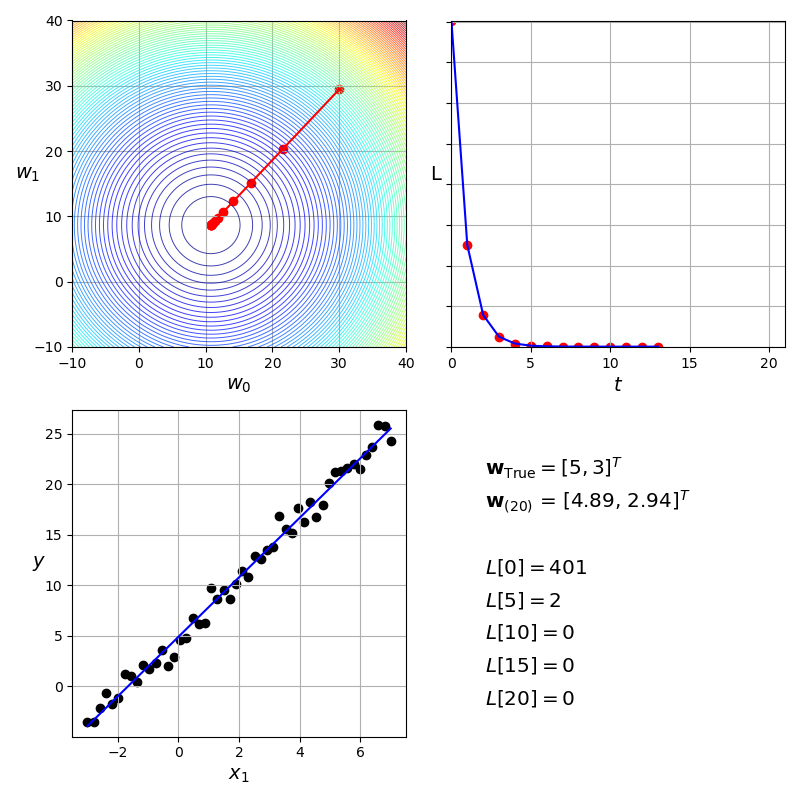

In [105]:
#Run animated plots of the outputs
plt.close('all')
fig = plt.figure(figsize=(8,8))


#PLOT 1: contour plot of L(t) v w_0(t),w_1(t)
ax1 = fig.add_subplot(2,2,1)
ax1.grid()
ax1.set_xlabel('$w_0$', fontsize=14)
ax1.set_ylabel('$w_1$', fontsize=14, rotation = 0)
#Plot loss surface
w0 = np.linspace(-10, 40, 100)
w1 = np.linspace(-10, 40, 100)
w0_grid, w1_grid = np.meshgrid(w0, w1)
y_grid = np.zeros([w0.size,w1.size])
for r in range(0,w0.size):
    for c in range(0, w1.size):
        w_vec = np.array([w0[r],w1[c]]).reshape(2,1)
        a = (y_train - np.matmul(X_train_scaled,w_vec))                  
        y_grid[c,r] = (1/(2*num_points)) * (a.T.dot(a))
ax1.contour(w0, w1, y_grid, 100, cmap=plt.cm.jet, linewidths=0.7, alpha=0.75)
#Placeholder for animated (w,L) points  
ax1_anim_point = ax1.scatter([], [], color='red')
#Placeholder for lines connecting animated (w,L) points  
ax1_anim_line, = ax1.plot([], [], marker='o', markersize=2, color='red')


#PLOT 2: L(t) v t
ax2 = fig.add_subplot(2,2,2)
ax2.grid()
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('$\mathsf{L}$', fontsize=14, rotation = 0)
ax2.set_yticklabels([])
#Set axis ranges
ax2.set_xlim(0, len(w_hist))
ax2.set_ylim(0, max(L_hist)[0])
#Placeholder for animated (t,L) points  
ax2_anim_point = ax2.scatter([], [], color='red')
#Placeholder for lines connecting animated (t,L) points  
ax2_anim_line, = ax2.plot([], [], color='blue')


#PLOT 3: Regression function
ax3 = fig.add_subplot(2,2,3)
ax3.grid()
ax3.set_xlabel('$x_1$', fontsize=14)
ax3.set_ylabel('$y$', fontsize=14, rotation = 0)
#Plot training data
ax3.scatter(x_train, y_train, color='black')
#Placeholder for animated regression line plots
ax3_anim_line, = ax3.plot([], [], color='blue')


#PLOT 4: Print interesting numbers
ax4 = fig.add_subplot(2,2,4)
ax4.set_axis_off()
#Print w and L numbers 
#Note that the weights are 'de-scaled' such that they can are applicable to the unscaled data
ax4.text(0.1,0.8,'$\mathbf{w}_{\mathsf{True}} = [5, 3]^T$', fontsize = 'x-large')
w1_unscaled = np.round(w_hist[-1][1]/sigma,2)
w0_unscaled = np.round(w_hist[-1][0] - mu*w1_unscaled ,2)
ax4.text(0.1,0.7,
         '$\mathbf{w}_{(20)}$ = ['+str(w0_unscaled)+', '+str(w1_unscaled)+'$]^T$',
         fontsize = 'x-large')
space = 1
for i in [0,5,10,15,20]:
    num = np.round(L_hist[i][0],0)    
    ax4.text(0.1,0.6 - 0.1*space,'$L[$' + str(i) + '$] = $'+str("{:,}".format(int(num))), fontsize = 'x-large')
    space += 1


#ANIMATION:
def animate(i): 
    ax1_anim_point.set_offsets(np.c_[w_hist[0:i,0],w_hist[0:i,1]])
    ax1_anim_line.set_data(w_hist[0:i,0], w_hist[0:i,1])

    ax2_anim_point.set_offsets(np.c_[np.arange(0, i, 1),L_hist[0:i]])    
    ax2_anim_line.set_data(np.arange(0, len(L_hist[0:i]), 1),L_hist[0:i])

    ax3_anim_line.set_data(x_train,w_hist[i,0] + w_hist[i,1]*x_train_scaled)
    return ax1_anim_point, ax1_anim_line, ax2_anim_point, ax2_anim_line, ax3_anim_line

ani = animation.FuncAnimation(fig, animate, frames=np.arange(max_epoch+10), 
                              interval=300, blit=True)

fig.tight_layout()
plt.show()

Great - the surface looks much better conditioned, and gradient descent seems to proceed much more directly to the optimal point.

### Stochastic Gradient Descent

The type of gradient descent procedure we have considered so far usually goes by the name of **batch gradient descent** (BGD). It's called this because we construct the gradient vector (correctly) using the full data set batch before we make an update step.

But there is an alternative, often faster, method known as **stochastic gradient descent** (SGD). Here we update the gradient vector using just one example, then perform an update step. This means that each step we make will no longer be in the direction of steepest descent, so that the loss will often jump up from one step to another, even for relative small $\alpha$ values. However, we are able to make updates much more rapidly so that overall SGD often convergence to an optimal solution faster than BGD.

<div class=question>
<b>Exercise:</b>

Write a function `LinearRegression_OLS_SGD` with:
- Inputs: `X_train`, a design matrix; `y_train`; `w_init`, an initial setting for $\mathbf{w}_{(0)}$; `alpha`, and; `max_epoch`, which limits the number of iterations for the procedure
- Outputs: `w_hist`, an array containing $\{\mathbf{w}_{(t)}\}_{t=1}^{n}$, and; `L_hist`, an array containing $\{\mathsf{L}_{(t)}\}_{t=1}^{n}$ - the evaluation of the loss at each iteration.


1. First initialise the arrays for `L_hist` and `w_hist`.


2. Set up a loop which ends when `max_epoch` is reached, and which generates the following at each pass:


- The training data is randomly shuffled
- The shuffled data is then looped through, one example at a time
- For each such example the gradient is updated using that example only, after which the weight vector is updated
- After one pass through the data the loss is updated
- The `L_hist` and `w_hist` arrays are updated with th emost recent loss and weight vector items.

</div>

In [106]:
# Ex
def LinearRegression_OLS_SGD(X_train, y_train, w_init, alpha, max_epoch=10):
    n = len(y_train)
    X = X_train
    y = y_train
    w_t = w_init
    
    # Ex 1
    # Initialise
    L_hist = (1/(2*n)) * (y - np.matmul(X,w_t)).T.dot(y - np.matmul(X,w_t))
    w_hist = w_t.T

    # Ex 2
    epoch = 0
    while epoch < max_epoch:
        np.random.seed(epoch)
        shuffled_indices = np.random.permutation(len(y))
        X = X[shuffled_indices,:]
        y = y[shuffled_indices]
        for i in range(n):
            grad = (1/n) * ( ((X[i].T).reshape(1,2)).dot(w_t) - y[i] ) * X[i].reshape(2,1)
            w_t = (w_t - alpha * grad)
        loss = (1/(2*n)) * (y - X.dot(w_t)).T.dot(y - X.dot(w_t))[0][0]
        L_hist = np.vstack((L_hist, loss))
        w_hist = np.vstack((w_hist,w_t.T))
        epoch = epoch + 1
    
    return w_hist, L_hist

Next we'll adopt the same workflow that we did when we applied BGD to the unscaled data and examine the resulting data via the same sort of plots:

In [107]:
#Generate one-dimensional data with a bit of noise
np.random.seed(42)
num_points = 50
x_train = np.linspace(-3,7,num_points).reshape(num_points,1)
y_train = 5 + 3 * x_train + 1*np.random.randn(num_points, 1)

In [119]:
#Create design matrix
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]

#Set parameters to be used in this experiment
max_epoch = max_epoch_global
alpha = alpha_global
w_init = w_init_global

#Run Stochastic Gradient Descent on the data
w_hist, L_hist = LinearRegression_OLS_SGD(X_train, y_train, w_init=w_init, alpha=alpha, max_epoch=max_epoch)

<IPython.core.display.Javascript object>


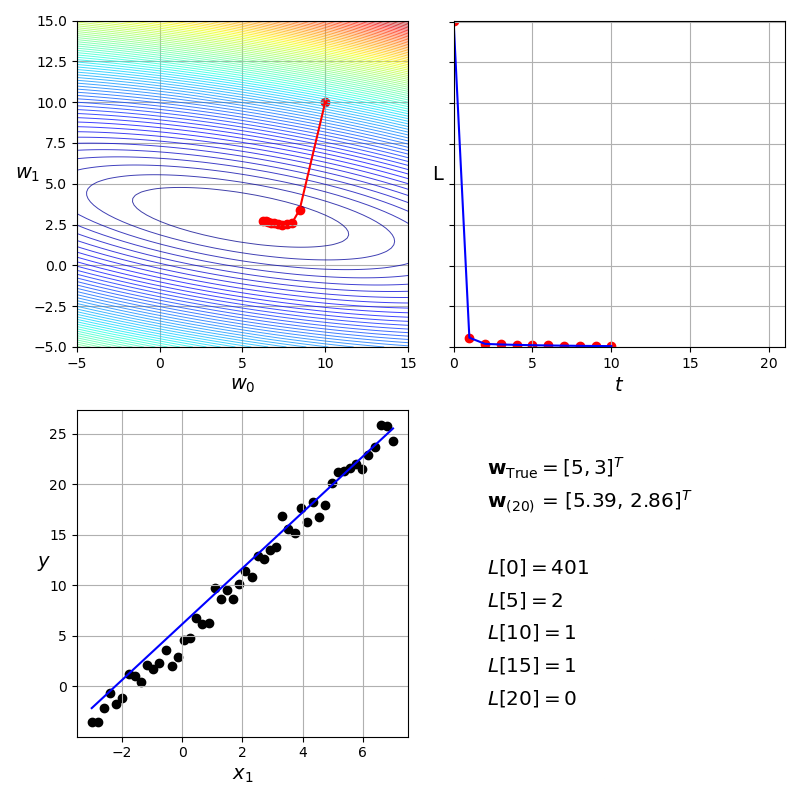

In [120]:
#Run animated plots of the outputs
plt.close('all')
fig = plt.figure(figsize=(8,8))


#PLOT 1: contour plot of L(t) v w_0(t),w_1(t)
ax1 = fig.add_subplot(2,2,1)
ax1.grid()
ax1.set_xlabel('$w_0$', fontsize=14)
ax1.set_ylabel('$w_1$', fontsize=14, rotation = 0)
#Plot loss surface
w0 = np.linspace(-5, 15, 100)
w1 = np.linspace(-5, 15, 100)
w0_grid, w1_grid = np.meshgrid(w0, w1)
y_grid = np.zeros([w0.size,w1.size])
for r in range(0,w0.size):
    for c in range(0, w1.size):
        w_vec = np.array([w0[r],w1[c]]).reshape(2,1)
        a = (y_train - np.matmul(X_train,w_vec))                  
        y_grid[c,r] = (1/(2*num_points)) * (a.T.dot(a))
ax1.contour(w0, w1, y_grid, 100, cmap=plt.cm.jet, linewidths=0.7, alpha=0.75)
#Placeholder for animated (w,L) points  
ax1_anim_point = ax1.scatter([], [], color='red')
#Placeholder for lines connecting animated (w,L) points  
ax1_anim_line, = ax1.plot([], [], marker='o', markersize=2, color='red')


#PLOT 2: L(t) v t
ax2 = fig.add_subplot(2,2,2)
ax2.grid()
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('$\mathsf{L}$', fontsize=14, rotation = 0)
ax2.set_yticklabels([])
#Set axis ranges
ax2.set_xlim(0, len(w_hist))
ax2.set_ylim(0, max(L_hist)[0])
#Placeholder for animated (t,L) points  
ax2_anim_point = ax2.scatter([], [], color='red')
#Placeholder for lines connecting animated (t,L) points  
ax2_anim_line, = ax2.plot([], [], color='blue')


#PLOT 3: Regression function
ax3 = fig.add_subplot(2,2,3)
ax3.grid()
ax3.set_xlabel('$x_1$', fontsize=14)
ax3.set_ylabel('$y$', fontsize=14, rotation = 0)
#Plot training data
ax3.scatter(x_train, y_train, color='black')
#Placeholder for animated regression line plots
ax3_anim_line, = ax3.plot([], [], color='blue')


#PLOT 4: Print interesting numbers
ax4 = fig.add_subplot(2,2,4)
ax4.set_axis_off()
#Print w and L numbers 
ax4.text(0.1,0.8,'$\mathbf{w}_{\mathsf{True}} = [5, 3]^T$', fontsize = 'x-large')
ax4.text(0.1,0.7,
         '$\mathbf{w}_{(20)}$ = ['+str(np.round(w_hist[-1][0],2))+', '+str(np.round(w_hist[-1][1],2))+'$]^T$', 
         fontsize = 'x-large')
space = 1
for i in [0,5,10,15,20]:
    num = np.round(L_hist[i][0],0)    
    ax4.text(0.1,0.6 - 0.1*space,'$L[$' + str(i) + '$] = $'+str("{:,}".format(int(num))), fontsize = 'x-large')
    space += 1


#ANIMATION:
def animate(i):    
    ax1_anim_point.set_offsets(np.c_[w_hist[0:i,0],w_hist[0:i,1]])
    ax1_anim_line.set_data(w_hist[0:i,0], w_hist[0:i,1])
    
    ax2_anim_point.set_offsets(np.c_[np.arange(0, i, 1),L_hist[0:i]])    
    ax2_anim_line.set_data(np.arange(0, len(L_hist[0:i]), 1),L_hist[0:i])
    
    ax3_anim_line.set_data(x_train,w_hist[i,0] + w_hist[i,1]*x_train)
    return ax1_anim_point, ax1_anim_line, ax2_anim_point, ax2_anim_line, ax3_anim_line

ani = animation.FuncAnimation(fig, animate, frames=np.arange(max_epoch+10), 
                              interval=300, blit=True)

fig.tight_layout()
plt.show()

Great, even with an unscaled surface the convergence seems much faster for SGD compared with BGD.

<div class=question>
<b>Exercise:</b>

Try adjusting setting the `alpha` parameter to a higher value, say 2.

What do you notice about the speed of convergence?

What do you notice about the change in loss from one step to the next.

</div>

<div class=answer>
<b>Answer:</b>

Algorithm converges more rapidly, however the change in loss from one step to the next is not monotonic, and the algorithm meanders around the optimal value.

</div>

<a id='section_PolyRegression'></a>
## 4. Polynomial Regression

The techniques of linear regression can be extended to learn richer function classes. How can this be? Because linear regression is linear *in terms of its unknown parameters* - the features which those parameters serve to multiply can be the outputs of functions of the initial observed attributes. These functions are know as **feature maps**, and as we will see in later topics they can give rise to very rich, even infinite dimensional, spaces in which we will attempt to learn patterns.  

But for the moment we will illustrate this concept with polynomial feature maps which give rise to **polynomial regression**.

### Single Attributes

We'll begin by considering polynomial regression in one attribute variable, but later we'll see that we can extend this analysis to multiple attribute dimensions.

In this setting we seek to learn functions of the following form:

\begin{equation*}
    f_{\mathbf{w}}(\mathbf{x})= w_0 + w_1 x + w_2 x^2 + \dots + w_k x^k
\end{equation*}

Here $k$ is the degree of the polynomial class which we are seeking to fit our data with, and we denote the weight vector by $\mathbf{w} = [w_0, w_1, \dots, w_k]^T$.

This all looks reminiscent of our original linear regression setting providing we express the design matrix as follows:
\begin{equation*}
    \mathbf{X} = \begin{bmatrix}
1, x^{(1)}, (x^{(1)})^2, \dots, (x^{(1)})^k  \\
1, x^{(2)}, (x^{(2)})^2, \dots, (x^{(2)})^k  \\
\vdots \\
1, x^{(n)}, (x^{(n)})^2, \dots, (x^{(n)})^k  \\
\end{bmatrix}
\end{equation*}

Let's illustrate this with some toy data generated by a cubic function which will represent our "ground truth" in the following experiments. Note that this time we will create two sets of data: the usual **training set** (`x_train`, `y_train`) that we will use to learn our polynomial functions, and another **validation set** (`x_train`, `y_train`) that will not be used for training, but that which will be used to illustrate the out-of-sample performance of our learned polynomials later.

<IPython.core.display.Javascript object>


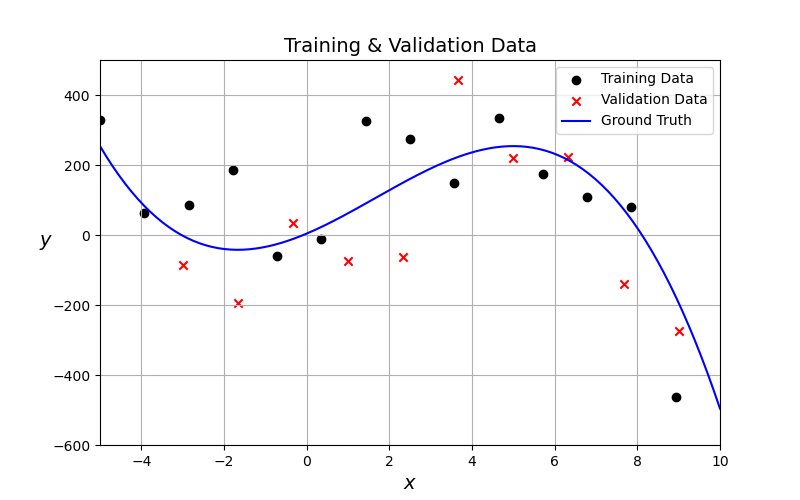

In [121]:
#Generate one-dimensional data with a bit of noise
def cubic_ground_truth(x_data, w1,w2,w3,w4):
    y_data = w1 + w2 * x_data + w3 * x_data**2 + w4 * x_data**3
    return y_data

def generate_1d_data(cubic_ground_truth):
    np.random.seed(42)
    num_points_train = 15
    x_train = np.linspace(-5,10,num_points_train).reshape(num_points_train,1)
    y_clean = cubic_ground_truth(x_train, w1=4,w2=50,w3=10,w4=-2)
    y_train = y_clean + 150*np.random.randn(num_points_train, 1)

    num_points_valid = 10
    x_valid = np.linspace(-3,9,num_points_valid).reshape(num_points_valid,1)
    y_valid = cubic_ground_truth(x_valid, w1=4,w2=50,w3=10,w4=-2) + 150*np.random.randn(num_points_valid, 1)

    #Denser data for use in plots
    num_points_plot = 200
    x_plot = np.linspace(-5,10,num_points_plot).reshape(num_points_plot,1)
    y_plot = cubic_ground_truth(x_plot, w1=4,w2=50,w3=10,w4=-2)

    return x_train, y_clean, y_train, x_valid, y_valid, x_plot, y_plot

x_train, y_clean, y_train, x_valid, y_valid, x_plot, y_plot = generate_1d_data(cubic_ground_truth)

fig, ax = plt.subplots(figsize=(8,5))
ax.grid()
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14, rotation = 0)
ax.set_xlim(-5, 10)
ax.set_ylim(-600, 500)
ax.scatter(x_train,y_train, color='black', label='Training Data')
ax.scatter(x_valid,y_valid, color='red', marker='x', label='Validation Data')
ax.plot(x_plot, y_plot, color='blue', label='Ground Truth')
ax.set_title('Training & Validation Data', fontsize=14)
ax.legend()

plt.show()

<div class=question>
<b>Exercise:</b>

SciKit-Learn contains a handy function, `PolynomialFeatures`, which will allow us to create ploynomial features from our input attribute data automatically.

1. Create polynomial features using, `PolynomialFeatures`, for a range of orders for different polynomial orders.

2. For each polynomial order `fit_transform` the values of `x_train` to create a design matrix, `X_poly_train`. Do the same thing for the `x_valid` and `x_plot` data which we'll use later - store this data as `X_poly_valid` and  `X_poly_plot` respectively

3. For each polynomial order scale the resulting features using `StandardScaler`. And again, use this scaling to scale the `x_valid` and `x_plot` data that we'll use later. Be careful - you'll need to think about when to use `fit_transform` and when to use `transform`. Store your results in `X_poly_scaled_train`, `X_poly_scaled_valid`, and `X_poly_scaled_plot` respectively.

4. For each polynomial function use the `LinearRegression` function to fit the transformed features on the training targets, `y_train`.

5. Then use your trained model to create predictions for `X_poly_scaled_train`, for each polynomial function, and store these predicitions in a vector `y_pred_train`. Again so the same thing for `X_poly_scaled_valid` and store the results in `ypred_valid`. And for `X_poly_scaled_plot` and store the results in `ypred_plot`. 

</div>

In [122]:
y_preds_train = []
y_preds_valid = []
y_preds_plot = []

poly_w = np.zeros((15, 16))
poly_norm = []

counter = 0
degrees = list(range(1,16)) #[1,2,3,5,10,15]
for degree in degrees:
    counter = counter + 1
    #Ex1
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    #NB this remvoves leading ones in design matrix - LinearRegression will take care of these so long as intercept=true
    
    #Ex2
    X_poly_train = poly_features.fit_transform(x_train)
    X_poly_valid = poly_features.fit_transform(x_valid)
    X_poly_plot = poly_features.fit_transform(x_plot)

    #Ex3
    scaler = StandardScaler()
    X_poly_scaled_train = scaler.fit_transform(X_poly_train)
    X_poly_scaled_valid = scaler.transform(X_poly_valid)
    X_poly_scaled_plot = scaler.transform(X_poly_plot)

    #Ex4
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly_scaled_train, y_train)
    
    #Ex5
    y_pred_train = lin_reg.predict(X_poly_scaled_train)
    y_pred_valid = lin_reg.predict(X_poly_scaled_valid)
    y_pred_plot = lin_reg.predict(X_poly_scaled_plot)
    
    #Please do not change code below
    y_preds_train.append(y_pred_train)
    y_preds_valid.append(y_pred_valid)
    y_preds_plot.append(y_pred_plot)
    
    #Here we store the data associated with the weight and intercept coefficients, together with their 2-norm
    poly_w_degree = np.append(lin_reg.intercept_, lin_reg.coef_).reshape(1,degree+1)
    poly_norm_degree = np.linalg.norm(lin_reg.coef_, ord='fro')
    poly_norm = np.append(poly_norm, poly_norm_degree)
    poly_w[counter-1,0:int(degree)+1] = poly_w_degree

Let's plot this set of predictions, together with the original data and the 'ground truth' that was used to generated the uncorrupted data:

<IPython.core.display.Javascript object>


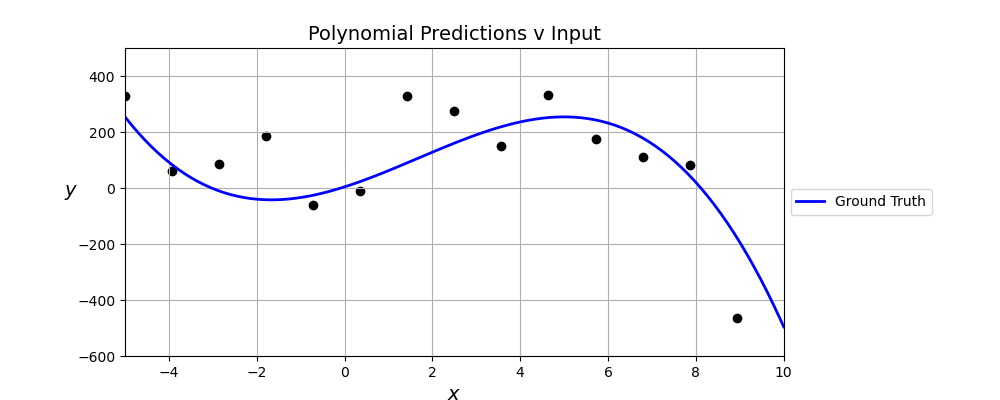

interactive(children=(Checkbox(value=False, description='Validation Data'), Checkbox(value=False, description=…

In [123]:
fig, ax = plt.subplots(figsize=(10,4))
box = ax.get_position()
box_width = box.width
box_height = box.height

def plot_2d_OLS(checkbox0, checkbox1, checkbox2, checkbox3, checkbox4, checkbox5, checkbox6):
    ax.clear()
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14, rotation = 0)
    ax.grid()
    ax.set_xlim(-5, 10)
    ax.set_ylim(-600, 500)

    ax.scatter(x_train,y_train, color='black')
    if checkbox0 == True:
        ax.scatter(x_valid,y_valid, marker='x', color='red')

    ax.plot(x_plot, y_plot, color='blue', linewidth=2, label='Ground Truth')
   
    if checkbox1 == True:
        ax.plot(x_plot, y_preds_plot[0], color='g', linewidth=1.0, label=str(degrees[0]) + "D polynomial")
    if checkbox2 == True:
        ax.plot(x_plot, y_preds_plot[1], color='r', linewidth=1.0, label=str(degrees[1]) + "D polynomial")
    if checkbox3 == True:
        ax.plot(x_plot, y_preds_plot[2], color='k', linewidth=1.0, label=str(degrees[2]) + "D polynomial")
    if checkbox4 == True:
        ax.plot(x_plot, y_preds_plot[4], color='m', linewidth=1.0, label=str(degrees[4]) + "D polynomial")
    if checkbox5 == True:
        ax.plot(x_plot, y_preds_plot[9], color='y', linewidth=1.0, label=str(degrees[9]) + "D polynomial")
    if checkbox6 == True:
        ax.plot(x_plot, y_preds_plot[14], color='c', linewidth=1.0, label=str(degrees[14]) + "D polynomial")
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box_width * 0.85, box_height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Polynomial Predictions v Input', fontsize=14)
    
int_plot = interact(plot_2d_OLS, 
                    checkbox0 = widgets.Checkbox(description = 'Validation Data', value=False),
                    checkbox1 = widgets.Checkbox(description = '1D polynomial', value=False),
                    checkbox2 = widgets.Checkbox(description = '2D polynomial', value=False),
                    checkbox3 = widgets.Checkbox(description = '3D polynomial', value=False),
                    checkbox4 = widgets.Checkbox(description = '5D polynomial', value=False),
                    checkbox5 = widgets.Checkbox(description = '10D polynomial', value=False),
                    checkbox6 = widgets.Checkbox(description = '15D polynomial', value=False)
                   )

plt.show()

### Overfitting & Underfitting ###

Notice that for low orders of polynomial we seem unable to fit the function which we know to be correct. On the other hand, as we increase the order of the polynomial we fit the training data better and better, so that by the time we use a 15-degree polynomial we are fitting the data perfectly...

But is this really what we want to do? A 15-degree polynomial will likely perform very badly on any new data generated from the 'ground truth' data generating process. Try switching on the 'Validation Data' in the plot above to see this point manifest.

Remember that in machine learning we really want to learn functions which minimise the **Generalisation Error**. But in (vanilla) polynomial regression, we have sought functions which minimise some sort of **Empirical Training Error**. Thus as we increase the order of the polynomial we are more likley to fit the **noise** rather than the **signal**. But if we restrict ourselves too much then we won't have a rich enough function class to model that signal at all.

Let's quantitfy this further by observing the performance of our learned functions on the **validation data** which we created earlier:

<div class=question>
<b>Exercise:</b>

1. For each polynomial order use the SciKit-Learn `mean_squared_error` function to generate the mean squared error for the training set and validation set predicitions.

2. Plot each of these against polynomial degree.

</div>

In [124]:
mse_train = []
mse_valid = []
for degree in degrees:
    # Ex1
    mse_train.append(mean_squared_error(y_train, y_preds_train[degree-1]))
    mse_valid.append(mean_squared_error(y_valid, y_preds_valid[degree-1]))

<IPython.core.display.Javascript object>


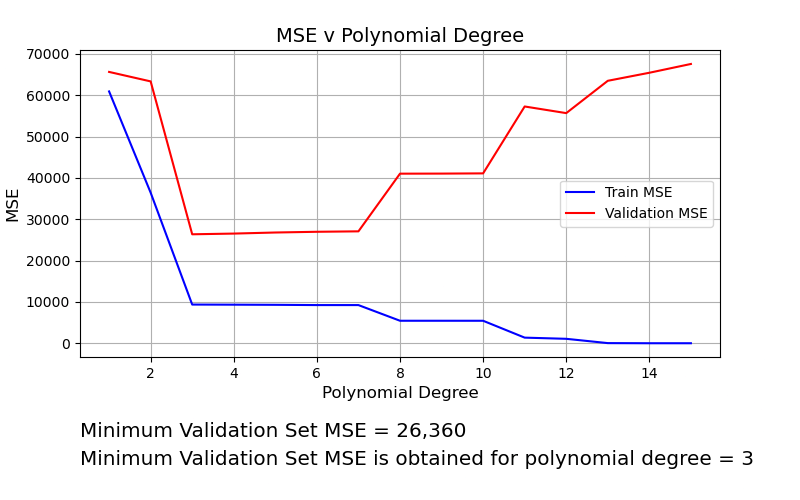

In [125]:
# Ex2
#plt.close('all')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [24, 1]})
ax1.grid()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    hspace=0.5)

#PLOT 1: MSE curves
ax1.set_xlabel('Polynomial Degree', fontsize=12)
ax1.set_ylabel('MSE', fontsize=12, rotation = 90)
ax1.plot(degrees, mse_train, color='blue', label='Train MSE')
ax1.plot(degrees, mse_valid, color='red', label='Validation MSE')
ax1.legend()
ax1.set_title('MSE v Polynomial Degree', fontsize=14)

#PLOT 2: Optimal MSE data
ax2.set_axis_off()
num2 = round(np.min(np.array(mse_valid)),0)
ax2.text(0,1.0,'Minimum Validation Set MSE = ' + str("{:,}".format(int(num2))), fontsize = 'x-large')
num1 = (degrees[np.argmin(np.array(mse_valid),axis=0)])
ax2.text(0,-1.2,'Minimum Validation Set MSE is obtained for polynomial degree = ' + str(num1), fontsize = 'x-large')

plt.show()

This plot exhibits behaviour that's typical of the so-called **bias / variance trade-off**: 

For low model class complexity (in this case low polynomial order) we typically see high error both within the training set and within the validation set. The polynomial order is too restricted, which leads to a learning algorithm that exhibits too much **bias** to be able to model the true pattern. We are in an **underfitting** regime.

For high model class complexity (in this case high polynomial order) we typically see low error within the training set, but high within the validation set. The polynomial order is too unrestricted, which leads to a learning algorithm that exhibits too much **variance** to be able to be reliablly used to discern the true pattern. We are in an **overfitting** regime.

There is a sweet-spot, in the case around degree 3 (as expected), where the validation error is at a minimum - this is an indication of which polynomial degree is the "best" for our modelling purposes.

We will touch on these considerations again in the section on [**Regularisation**](#section_Regularisation) later.

It's also worth noting at this point the behaviour of the magnitude of the coefficients of these functions as the degree of the polynomial increases:

<IPython.core.display.Javascript object>


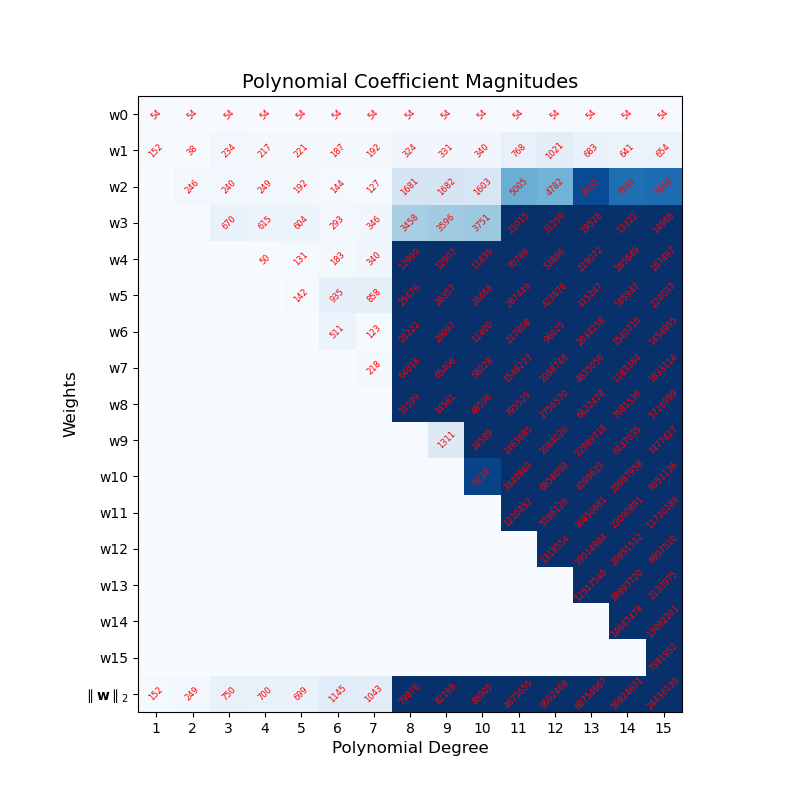

In [126]:
plt.close('all')

matrix_poly_w = np.c_[np.abs(poly_w), poly_norm]

fig = plt.figure(figsize=(8,8))

cmap = 'Blues'
normalize_cmap = 10000

ax0 = fig.add_subplot(1,1,1)

weight_ticks = list(range(0,16))
weight_labels = []
for i in weight_ticks:
    weight_labels.append('w'+str(i))
weight_labels.append('$ \parallel \mathbf{w} \parallel_2 $')

poly_log_degree_ticks = degrees
poly_log_degree_labels = []
for i in poly_log_degree_ticks:
    poly_log_degree_labels.append(str(int(i)))
    
im0 = ax0.imshow(matrix_poly_w.T, cmap=cmap, norm=plt.Normalize(0, normalize_cmap))

# Show all ticks and label them with the respective list entries
ax0.set_yticks(np.arange(len(weight_ticks) + 1))
ax0.set_yticklabels(weight_labels)
ax0.set_xticks(np.arange(len(poly_log_degree_ticks)))
ax0.set_xticklabels(poly_log_degree_labels)


# Loop over data dimensions and create text annotations.
for i in range(len(poly_log_degree_ticks)):
    for j in range(len(weight_ticks) + 1):
        if j<i+2 or j==len(weight_ticks):
            text = ax0.text(i, j, int(matrix_poly_w[i, j]),
                       ha="center", va="center", color="red", fontsize=6, rotation=45)

ax0.set_title("Polynomial Coefficient Magnitudes", fontsize=14)
ax0.set_ylabel('Weights', fontsize=12)
ax0.set_xlabel('Polynomial Degree', fontsize=12, rotation = 0)

plt.show()

Notice that as the degree of the polynomial increases the magnitude of the weights tend to increase also - in particular the $\ell_2$ norm of the weight vector increases.

In some sense the magnitude of the weights seems to be associated with functional complexity.

Again, we will return to this consideration in the [**Regularisation**](#section_Regularisation) section.

### Multiple Attributes ###

Let's close by considering multiple attributes. Can we still apply polynomial regression in these settings? Yes - we simply extend the design matrix to the right in order to accomodate the additional attributes, their associated polynomial features, and any cross terms with the other attributes.

For example in 2 attribute dimensions $(x_1, x_2)$, with a 2nd degree polynomial we would seek to learn functions of the following form:

\begin{equation*}
    f_{\mathbf{w}}(\mathbf{x})= w_0 + w_1 x_1 + w_2 x_2 + w_3 x_{1}^2 + w_4 x_{1} x_{2} + w_5 x_{2}^2 
\end{equation*}

Let's see what a workflow designed to model such a relationship might look like on some 2-dimensional toy data:

<IPython.core.display.Javascript object>


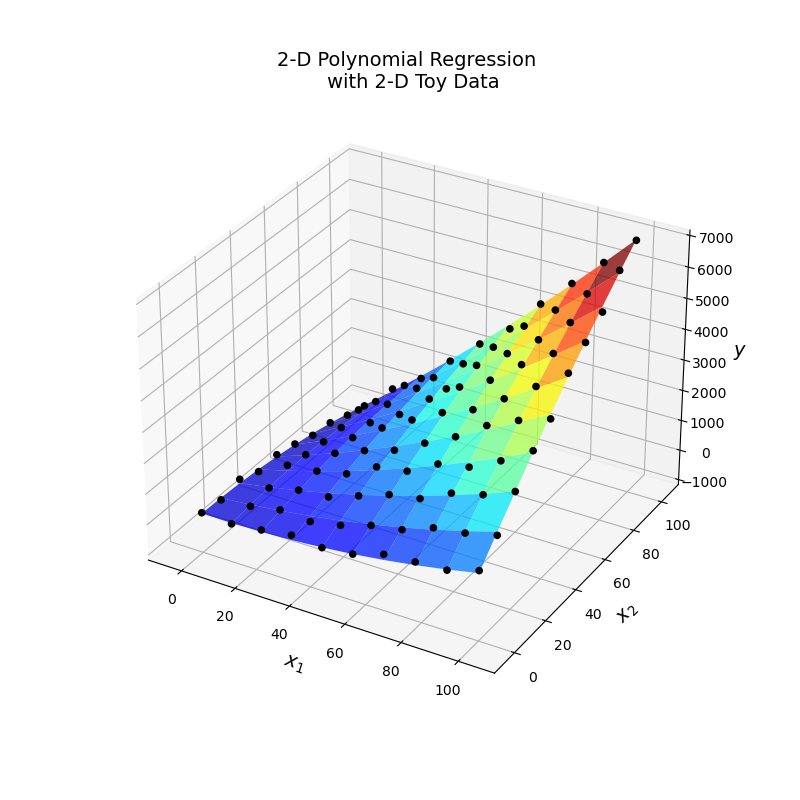

interactive(children=(IntSlider(value=10, description='num_points', max=40, min=5, step=5), IntSlider(value=10…

In [127]:
np.random.seed(42)

def d2_quadratic_ground_truth(x1_data, x2_data, w0, w1, w2, w3, w4, w5):
    y_data = w0 + w1*x1_data + w2*x2_data + w3*x1_data**2 + w4*x1_data*x2_data + w5*x2_data**2
    return y_data

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection="3d")

def plot_2d_OLS(num_points, sigma):
    np.random.seed(42)
    ax.clear()

    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_zlabel('$y$', fontsize=14)
    
    ax.set_xlim(-10, 110)
    ax.set_ylim(-10, 110)
    ax.set_zlim(-1000, 7000)
    
    x1_train = np.linspace(0,100,num_points).reshape(num_points,1)
    x2_train = np.linspace(0,100,num_points).reshape(num_points,1)
    xx1_train, xx2_train = np.meshgrid(x1_train, x2_train)
    yy_clean = d2_quadratic_ground_truth(xx1_train, xx2_train, w0=100, w1=-0.5, w2=0.3, w3=0.1, w4=0.7, w5=-0.1)
    yy_train = yy_clean + sigma*np.random.randn(num_points, num_points)
    
    X_train = np.c_[xx1_train.ravel(), xx2_train.ravel()]
    y_train = np.c_[yy_train.ravel()]

    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    
    #Ex2
    X_poly_train = poly_features.fit_transform(X_train)

    #Ex3
    scaler = StandardScaler()
    X_poly_scaled_train = scaler.fit_transform(X_poly_train)

    #Ex4
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly_scaled_train, y_train)
        
    #Ex5
    y_pred_train = lin_reg.predict(X_poly_scaled_train)
        
    pts = ax.scatter(xx1_train, xx2_train, yy_train, color='black', alpha=1)
    reg = ax.plot_surface(xx1_train, xx2_train, y_pred_train.reshape(num_points,num_points), cmap=plt.cm.jet, alpha=0.75)

    ax.set_title('2-D Polynomial Regression \n with 2-D Toy Data', fontsize=14)

    plt.show()
    
int_plot = interact(plot_2d_OLS, 
                    num_points = widgets.IntSlider(value=10, min=5, max=40, step=5), 
                    sigma = widgets.IntSlider(value=100, min=0, max=1500, step=25))

<div class=question>
<b>Exercise:</b>

Try adjusting the values of `num_points` and `sigma`, which control the number of points in our training data, and the corruption of the outputs of those data points by noise respectively. 

What do you observe about the OLS regression surface as these values vary?

</div>

<div class=answer>
<b>Answer:</b>

Similar observations to the linear case.

</div>

If you happen to be interested in extracting the weight vector from the fitted `LinearRegression` object then remember to check the Scikit-Learn documentation for the ordering of the expansion of polynomial features. After this, you'll be able to construct the weight vector out of the `intercept_` attribute and the `coef_` attribute which should contain an ordered set of weights excluding the bias term (provided that you set `include_bias=False` in `PolynomialFeatures`.

Of course if you scaled your data (using, for example `StandardScaler`) then don't be surprised if your weights bear little rsemblance to your ground truth - remember you need to scale the weights equivalently in order to compare the vectors meaningfully.

<a id='section_Regularisation'></a>
## 5. Regularisation

Let's consider again what happened as the degree of the polynomial increased - the potential for overfitting becomes manifest. 

The set of techniques known as **regularisation** seek to manage this model complexity somehow to alleviate this effect.

Remember also that as the degree of the polynomial increased, the size of the weights in our regression also increased. 

It turns out that larger magnitude weights are somehow related to higher complexity. We can demonstrate this via various avenues ranging from Bayesian analysis to statistical learning theory. 

But in any event a tried an tested technique for managing model complexity - and thus the potential for overfitting - is to **shrink** the weights towards zero somehow.

This is achieved by imposing **constraints** on the values of $\mathbf{w}$. We'll ivestigate two such weight constraining techniques: **Ridge Regression** and the **LASSO**.

### Ridge Regression ###

In Ridge Regression we seek to constrain the $\ell_2$ norm of the weight vector so that our optimisation problem becomes:
\begin{align*}
   \min_{\mathbf{w}} &\frac{1}{2n}\sum_{i=1}^n \left( y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \right)^2 \\
   \mbox{subject to:} &\Vert \mathbf{w} \Vert_2^2 \leq t 
\end{align*}
Where $t$ is some threshold.

Using the theory of **Lagrange Multipliers** we can show that this is equivalent to the following problem:
\begin{align*}
   \min_{\mathbf{w}} \frac{1}{2n}\sum_{i=1}^n \left( y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \right)^2 + \frac{\lambda}{2}  \Vert \mathbf{w} \Vert_2^2 
\end{align*}
Where $\lambda > 0$ (if $t$ is low enough for the contraint to be active, in which case $\lambda$ and $t$ are inversely related to one another).



<div class=question>
<b>Exercise:</b>

Adopt the same workflow as in section 4, but this time embed the workflow in a function, `get_Regularised_Regression_Data` that we can re-use when we run our next set of experiments:

1. Create polynomial features using, `PolynomialFeatures`, for a polynomial.

2. `fit_transform` the values of `x_train` to create a design matrix, `X_poly_train`. Do the same thing for the `x_valid` and `x_plot` data which we'll use later - store this data as `X_poly_valid` and  `X_poly_plot` respectively

3. Scale the resulting features using `StandardScaler`. And again, use this scaling to scale the `x_valid` and `x_plot` data that we'll use later. Be careful - you'll need to think about when to use `fit_transform` and when to use `transform`. Store your results in `X_poly_scaled_train`, `X_poly_scaled_valid`, and `X_poly_scaled_plot` respectively.

4. For each setting of $\lambda$ use a function, `reg_type`, an input to `get_Regularised_Regression_Data`, to fit the transformed features on the training targets, `y_train`.

5. Use your trained model to create predictions for `X_poly_scaled_train`, for each setting of $\lambda$, and store these predicitions in a vector `Reg_y_pred_train`. Again so the same thing for `X_poly_scaled_valid` and store the results in `Reg_y_pred_valid`. And for `Reg_X_poly_scaled_plot` and store the results in `Reg_y_pred_plot`. 

6. Run your function with the inputs given below.
</div>

In [132]:
#First generate 1-d data as in Section 4:
x_train, y_clean, y_train, x_valid, y_valid, x_plot, y_plot = generate_1d_data(cubic_ground_truth)

In [133]:
def get_Regularised_Regression_Data(reg_type, lambda_list, polynomial_degree, norm_order, 
                                    x_train, x_valid, x_plot, y_train, y_valid):
    #Run Regularised Regression on 15-D Polynomial data for range of lambda hyperparameters
    Reg_lambds = lambda_list
    Reg_y_preds_train = []
    Reg_y_preds_valid = []
    Reg_y_preds_plot = []
    Reg_mse_train = []
    Reg_mse_valid = []
    Reg_w = []
    Reg_norm = []

    #Ex 1
    poly_features = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    #Nb this remvoves leading ones in design matrix - LinearRegression will take care of these so long as intercept=true

    #Ex 2
    X_poly_train = poly_features.fit_transform(x_train)
    X_poly_valid = poly_features.fit_transform(x_valid)
    X_poly_plot = poly_features.fit_transform(x_plot)

    #Ex 3
    scaler = StandardScaler()
    X_poly_scaled_train = scaler.fit_transform(X_poly_train)
    X_poly_scaled_valid = scaler.transform(X_poly_valid)
    X_poly_scaled_plot = scaler.transform(X_poly_plot)

    counter = 0
    for lambd in Reg_lambds:
        counter += 1

        #Ex 4
        Reg_reg = reg_type(alpha=lambd)
        Reg_reg.fit(X_poly_scaled_train, y_train)

        #Ex 5
        Reg_y_pred_train = Reg_reg.predict(X_poly_scaled_train)
        Reg_y_pred_valid = Reg_reg.predict(X_poly_scaled_valid)
        Reg_y_pred_plot = Reg_reg.predict(X_poly_scaled_plot)

        #Please do not change code below
        Reg_y_preds_train.append(Reg_y_pred_train)
        Reg_y_preds_valid.append(Reg_y_pred_valid)
        Reg_y_preds_plot.append(Reg_y_pred_plot)

        #Here we store the data associated with the weight and intercept coefficients, together with their 2-norm
        Reg_w_lambd = np.append(Reg_reg.intercept_, Reg_reg.coef_).reshape(1,polynomial_degree+1)
        Reg_norm_lambd = np.linalg.norm(Reg_reg.coef_, ord=norm_order)
        Reg_norm = np.append(Reg_norm, Reg_norm_lambd)
        Reg_w = np.append(Reg_w, Reg_w_lambd).reshape(counter,polynomial_degree+1)

        Reg_mse_train.append(mean_squared_error(y_train, Reg_y_pred_train))
        Reg_mse_valid.append(mean_squared_error(y_valid, Reg_y_pred_valid))
    
    return Reg_y_preds_train, Reg_y_preds_valid, Reg_y_preds_plot, Reg_mse_train, Reg_mse_valid, Reg_w, Reg_norm, X_poly_scaled_train, X_poly_scaled_plot

In [134]:
polynomial_degree = 15
reg_type = Ridge
norm_order = 2
RR_lambds = 10**(np.arange(-13.0,6.0, 1))

#Ex 6
RR1, RR2, RR3, RR4, RR5, RR6, RR7, RR8, RR9 = get_Regularised_Regression_Data(reg_type, RR_lambds, 
                                                                              polynomial_degree, norm_order, 
                                                                              x_train, x_valid, x_plot, 
                                                                              y_train, y_valid)
RR_y_preds_train = RR1
RR_y_preds_valid = RR2
RR_y_preds_plot = RR3
RR_mse_train = RR4
RR_mse_valid = RR5
RR_w = RR6
RR_norm = RR7
X_poly_scaled_train = RR8
X_poly_scaled_plot = RR9

Now let's plot this display this data using three plots:

- a heatmap of the ridge regression coefficient magnitudes
- a plot of the regulaised 15-degree polynomial learned
- the training and validation MSE's plotted against the $\lambda$ hyperparameter

<IPython.core.display.Javascript object>


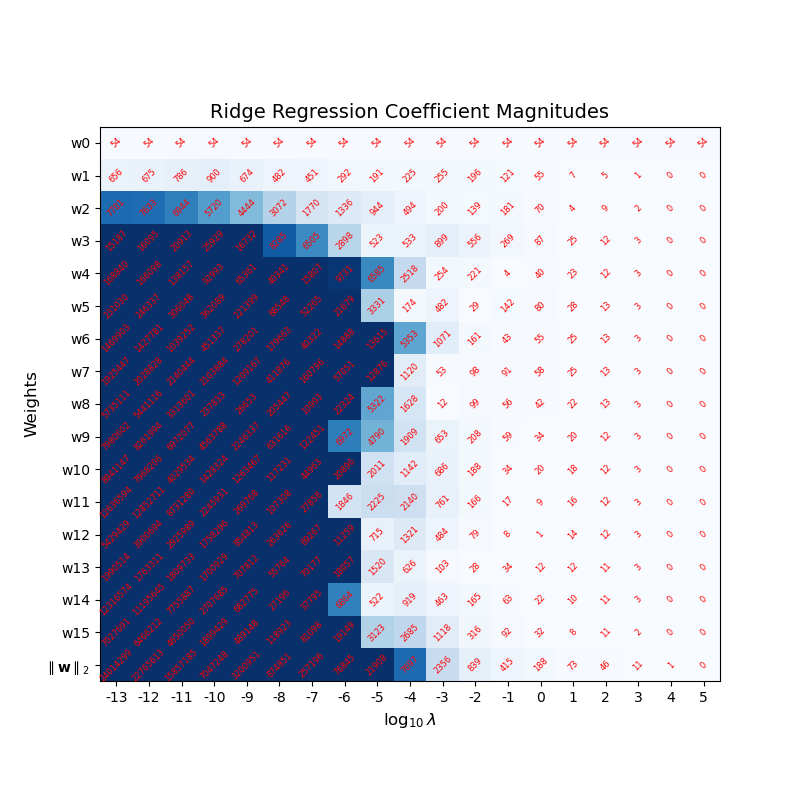

<IPython.core.display.Javascript object>


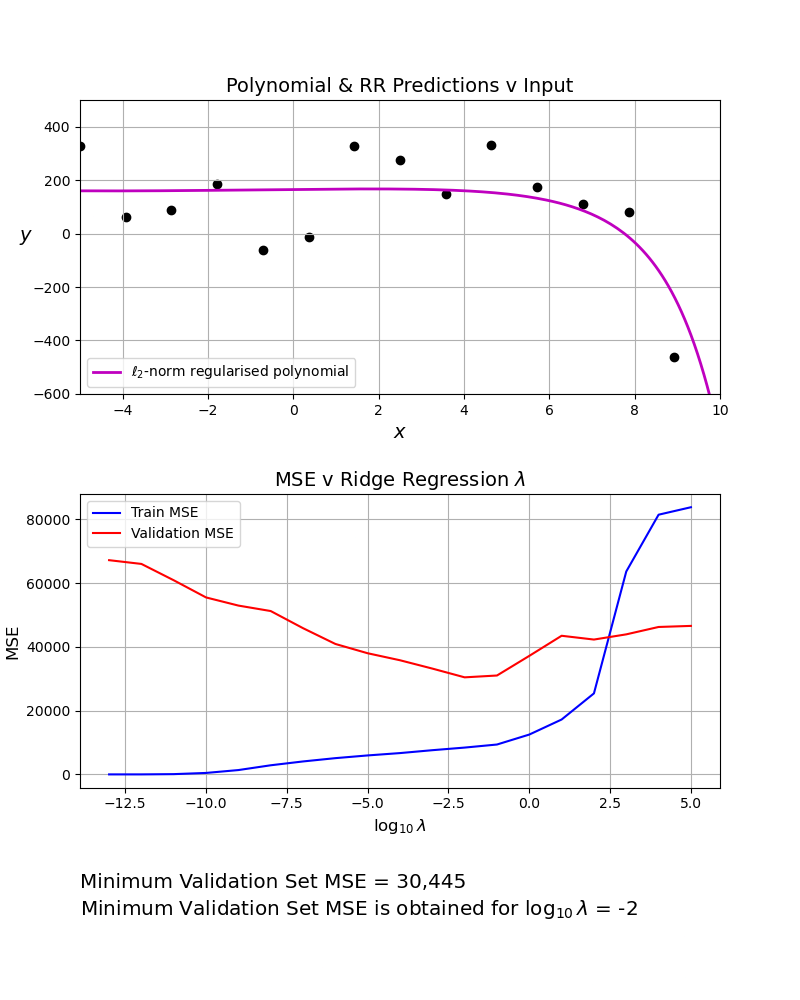

interactive(children=(Checkbox(value=False, description='Validation Data'), Checkbox(value=False, description=…

In [135]:
plt.close('all')

matrix_RR_w = np.c_[np.abs(RR_w), RR_norm]

#PLOT 1: coefficient matrix
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1,1,1)

matrix_RR_w = np.c_[np.abs(RR_w), RR_norm]

cmap = 'Blues'
normalize_cmap = 10000

weight_ticks = list(range(0,16))
weight_labels = []
for i in weight_ticks:
    weight_labels.append('w'+str(i))
weight_labels.append('$ \parallel \mathbf{w} \parallel_2 $')

RR_log_lambds_ticks = np.log10(RR_lambds)
RR_log_lambds_labels = []
for i in RR_log_lambds_ticks:
    RR_log_lambds_labels.append(str(int(i)))
    
im0 = ax0.imshow(matrix_RR_w.T, cmap=cmap, norm=plt.Normalize(0, normalize_cmap))

# Show all ticks and label them with the respective list entries
ax0.set_yticks(np.arange(len(weight_ticks) + 1))
ax0.set_yticklabels(weight_labels)
ax0.set_xticks(np.arange(len(RR_log_lambds_ticks)))
ax0.set_xticklabels(RR_log_lambds_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(RR_log_lambds_ticks)):
    for j in range(len(weight_ticks) + 1):
        text = ax0.text(i, j, int(matrix_RR_w[i, j]),
                       ha="center", va="center", color="red", fontsize=6, rotation=45)

ax0.set_title("Ridge Regression Coefficient Magnitudes",  fontsize=14)
ax0.set_ylabel('Weights', fontsize=12)
ax0.set_xlabel('$\log_{10}\lambda$', fontsize=12, rotation = 0)
plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,10), gridspec_kw={'height_ratios': [24, 24, 1]})

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    hspace=0.5)

def plot_Reg_Plots(checkbox0, checkbox1, checkbox2, log_lambda):
    reg_type = Ridge
    ax1.clear()
    ax1.grid()
    ax1.set_xlabel('$x$', fontsize=14)
    ax1.set_ylabel('$y$', fontsize=14, rotation = 0)
    ax1.set_xlim(-5, 10)
    ax1.set_ylim(-600, 500)

    ax1.scatter(x_train,y_train, color='black')
    if checkbox0 == True:
        ax1.scatter(x_valid,y_valid, marker='x', color='red')
    if checkbox1 == True:
        ax1.plot(x_plot, y_plot, color='blue', linewidth=2, label='Ground Truth')
    if checkbox2 == True:
        ax1.plot(x_plot, y_preds_plot[14], color='c', linewidth=1.5, label=str(degrees[14]) + "D polynomial")

    ridge_reg = reg_type(alpha=10**log_lambda)
    ridge_reg.fit(X_poly_scaled_train, y_train)
    RR_y_pred_plot = ridge_reg.predict(X_poly_scaled_plot)

    ax1.plot(x_plot, RR_y_pred_plot, color='m', linewidth=2.0, label="$\ell_2$-norm regularised polynomial")
    ax1.legend(loc='lower left')
    ax1.set_title('Polynomial & RR Predictions v Input', fontsize=14)
    
int_plot = interact(plot_Reg_Plots,
                    checkbox0 = widgets.Checkbox(description = 'Validation Data', value=False),
                    checkbox1 = widgets.Checkbox(description = 'Ground Truth', value=False),
                    checkbox2 = widgets.Checkbox(description = '15D Polynomial', value=False),
                    log_lambda = widgets.IntSlider(description = '$log_{10}\lambda$', value=1, min=-13, max=5, step=1),
                   )

#PLOT 2: MSE curves
ax2.grid()
ax2.set_xlabel('$\log_{10}\lambda$', fontsize=12)
ax2.set_ylabel('MSE', fontsize=12, rotation = 90)
RR_ln_lambds = np.log10(RR_lambds)
ax2.plot(RR_ln_lambds, RR_mse_train, color='blue', label='Train MSE')
ax2.plot(RR_ln_lambds, RR_mse_valid, color='red', label='Validation MSE')
ax2.legend()
ax2.set_title('MSE v Ridge Regression $\lambda$', fontsize=14)

#PLOT 3: Optimal MSE data
ax3.set_axis_off()
num2 = round(np.min(np.array(RR_mse_valid)),0)
ax3.text(0,1.0,'Minimum Validation Set MSE = ' + str("{:,}".format(int(num2))), fontsize = 'x-large')
num1 = np.log10(RR_lambds[np.argmin(np.array(RR_mse_valid),axis=0)])
ax3.text(0,-1.2,'Minimum Validation Set MSE is obtained for $\log_{10}\lambda$ = ' + str(int(num1)), fontsize = 'x-large')

plt.show()

<div class=question>
<b>Exercise:</b>

What do you notice about how the weights vary as the degree of regularisation (i.e. the size of $\lambda$) increases?

Try adjusting the value of $log_{10} \lambda$. Notice that even with a 15-degree polynomial: Regularisation will allow you to constrain the weights such that the regression learns a function very close to the gorund truth cubic function.
</div>

<div class=answer>
<b>Answer:</b>

As the degree of regularisation increases the magnitude of the weights diminishes.


</div>

### LASSO

What if we would like to do more than simply constrain the weights - we would also like to use our regularisation procedure to implement **feature selection**, in other words we would like the procedure to switch off (i.e. set to zero) unimportant weights.

In this case we could adopt the LASSO. Here we seek to constrain the $\ell_1$ norm of the weight vector so that our optimisation problem becomes:
\begin{align*}
   \min_{\mathbf{w}} &\frac{1}{2n}\sum_{i=1}^n \left( y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \right)^2 \\
   \mbox{subject to:} &\Vert \mathbf{w} \Vert_1 \leq t 
\end{align*}
Where $t$ is some threshold.

As before it's possible to show that this is equivalent to the following problem:
\begin{align*}
   \min_{\mathbf{w}} \frac{1}{2n}\sum_{i=1}^n \left( y^{(i)} - \mathbf{w} \cdot \mathbf{x}^{(i)} \right)^2 + \frac{\lambda}{2}  \Vert \mathbf{w} \Vert_1 
\end{align*}
Where $\lambda > 0$ (if $t$ is low enough for the contraint to be active).



<div class=question>
<b>Exercise:</b>

Adopt the same workflow as before, but this time do so by invoking `get_Regularised_Regression_Data` with appropriate inputs (look up the Scikit-learn LASSO regression object).

</div>

In [136]:
# Ex:
polynomial_degree = 15
reg_type = Lasso
norm_order = 1
L_lambds = 10**(np.arange(-4.0,5.0, 1))

#Ex 6
L1, L2, L3, L4, L5, L6, L7, L8, L9 = get_Regularised_Regression_Data(reg_type, L_lambds, polynomial_degree, 
                                                                     norm_order, x_train, x_valid, x_plot, 
                                                                     y_train, y_valid)
L_y_preds_train = L1
L_y_preds_valid = L2
L_y_preds_plot = L3
L_mse_train = L4
L_mse_valid = L5
L_w = L6
L_norm = L7
X_poly_scaled_train = L8
X_poly_scaled_plot = L9

/home/dariush/anaconda3/envs/ucl_summer_school/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+04, tolerance: 1.261e+02
  model = cd_fast.enet_coordinate_descent(
/home/dariush/anaconda3/envs/ucl_summer_school/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.448e+04, tolerance: 1.261e+02
  model = cd_fast.enet_coordinate_descent(
/home/dariush/anaconda3/envs/ucl_summer_school/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

<IPython.core.display.Javascript object>


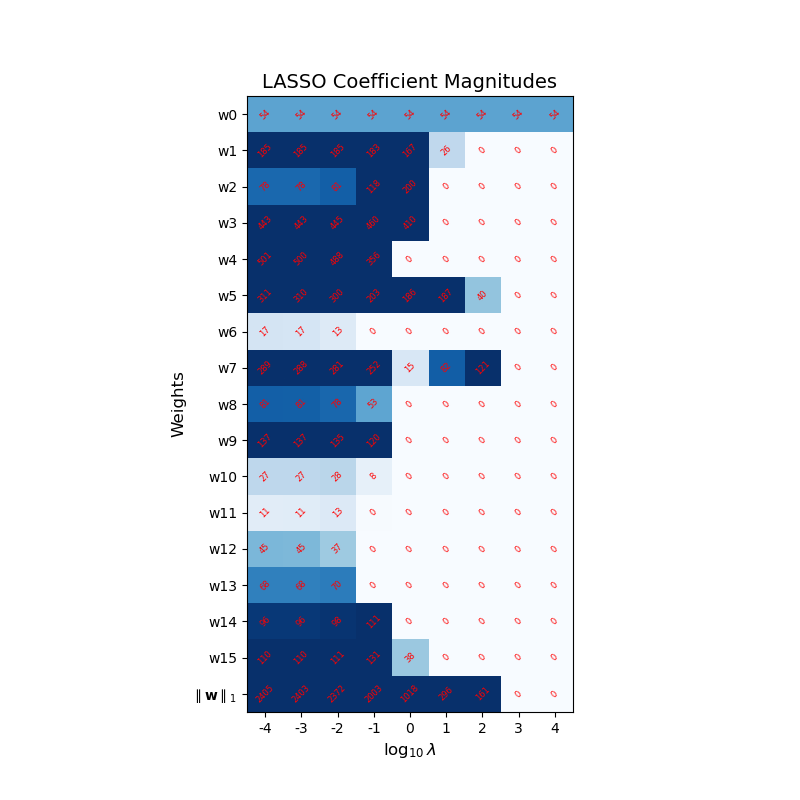

<IPython.core.display.Javascript object>


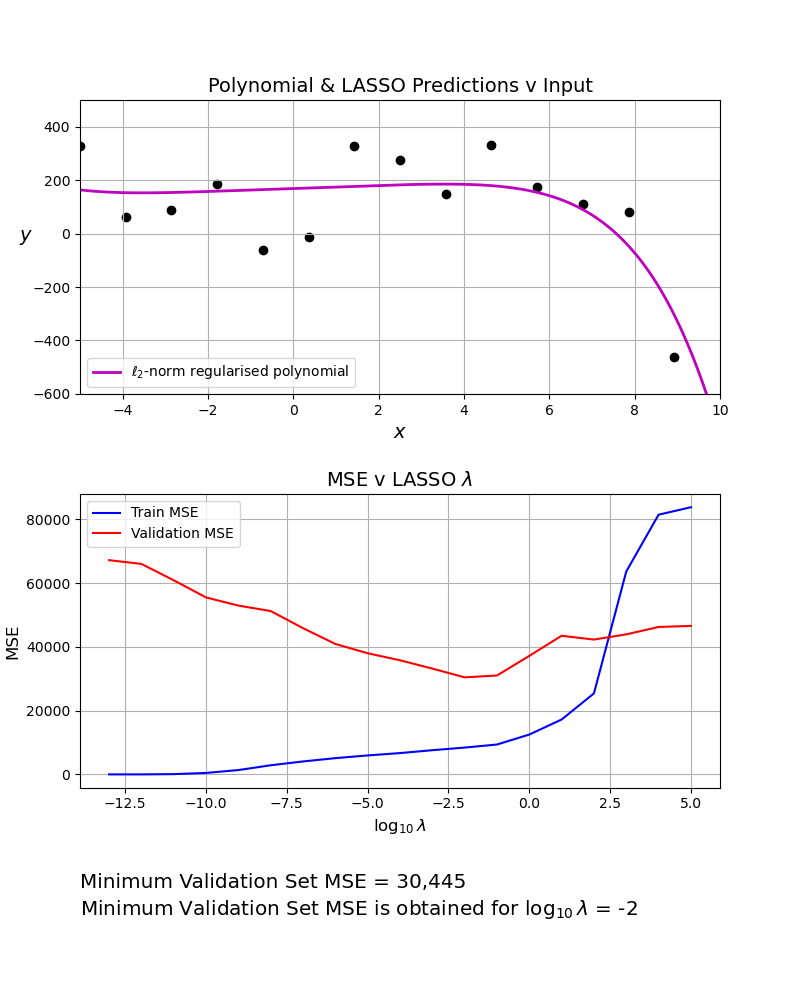

interactive(children=(Checkbox(value=False, description='Validation Data'), Checkbox(value=False, description=…

In [137]:
plt.close('all')

matrix_L_w = np.c_[np.abs(L_w), L_norm]

#PLOT 1: coefficient matrix
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1,1,1)

matrix_L_w = np.c_[np.abs(L_w), L_norm]

cmap = 'Blues'
normalize_cmap = 100

weight_ticks = list(range(0,16))
weight_labels = []
for i in weight_ticks:
    weight_labels.append('w'+str(i))
weight_labels.append('$ \parallel \mathbf{w} \parallel_1 $')

L_log_lambds_ticks = np.log10(L_lambds)
L_log_lambds_labels = []
for i in L_log_lambds_ticks:
    L_log_lambds_labels.append(str(int(i)))
    
im0 = ax0.imshow(matrix_L_w.T, cmap=cmap, norm=plt.Normalize(0, normalize_cmap))

# Show all ticks and label them with the respective list entries
ax0.set_yticks(np.arange(len(weight_ticks) + 1))
ax0.set_yticklabels(weight_labels)
ax0.set_xticks(np.arange(len(L_log_lambds_ticks)))
ax0.set_xticklabels(L_log_lambds_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(L_log_lambds_ticks)):
    for j in range(len(weight_ticks) + 1):
        text = ax0.text(i, j, int(matrix_L_w[i, j]),
                       ha="center", va="center", color="red", fontsize=6, rotation=45)

ax0.set_title("LASSO Coefficient Magnitudes",  fontsize=14)
ax0.set_ylabel('Weights', fontsize=12)
ax0.set_xlabel('$\log_{10}\lambda$', fontsize=12, rotation = 0)
plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,10), gridspec_kw={'height_ratios': [24, 24, 1]})

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    hspace=0.5)

def plot_Reg_Plots(checkbox0, checkbox1, checkbox2, log_lambda):
    reg_type = Lasso
    ax1.clear()
    ax1.grid()
    ax1.set_xlabel('$x$', fontsize=14)
    ax1.set_ylabel('$y$', fontsize=14, rotation = 0)
    ax1.set_xlim(-5, 10)
    ax1.set_ylim(-600, 500)

    ax1.scatter(x_train,y_train, color='black')
    if checkbox0 == True:
        ax1.scatter(x_valid,y_valid, marker='x', color='red')
    if checkbox1 == True:
        ax1.plot(x_plot, y_plot, color='blue', linewidth=2, label='Ground Truth')
    if checkbox2 == True:
        ax1.plot(x_plot, y_preds_plot[14], color='c', linewidth=1.5, label=str(degrees[14]) + "D polynomial")

    ridge_reg = reg_type(alpha=10**log_lambda)
    ridge_reg.fit(X_poly_scaled_train, y_train)
    RR_y_pred_plot = ridge_reg.predict(X_poly_scaled_plot)

    ax1.plot(x_plot, RR_y_pred_plot, color='m', linewidth=2.0, label="$\ell_2$-norm regularised polynomial")
    ax1.legend(loc='lower left')
    ax1.set_title('Polynomial & LASSO Predictions v Input', fontsize=14)

int_plot = interact(plot_Reg_Plots,
                    reg_type = Lasso,
                    checkbox0 = widgets.Checkbox(description = 'Validation Data', value=False),
                    checkbox1 = widgets.Checkbox(description = 'Ground Truth', value=False),
                    checkbox2 = widgets.Checkbox(description = '15D Polynomial', value=False),
                    log_lambda = widgets.IntSlider(description = '$log_{10}\lambda$', value=1, min=-13, max=5, step=1),
                   )

#PLOT 2: MSE curves
ax2.grid()
ax2.set_xlabel('$\log_{10}\lambda$', fontsize=12)
ax2.set_ylabel('MSE', fontsize=12, rotation = 90)
RR_ln_lambds = np.log10(RR_lambds)
ax2.plot(RR_ln_lambds, RR_mse_train, color='blue', label='Train MSE')
ax2.plot(RR_ln_lambds, RR_mse_valid, color='red', label='Validation MSE')
ax2.legend()
ax2.set_title('MSE v LASSO $\lambda$', fontsize=14)

#PLOT 3: Optimal MSE data
ax3.set_axis_off()
num2 = round(np.min(np.array(RR_mse_valid)),0)
ax3.text(0,1.0,'Minimum Validation Set MSE = ' + str("{:,}".format(int(num2))), fontsize = 'x-large')
num1 = np.log10(RR_lambds[np.argmin(np.array(RR_mse_valid),axis=0)])
ax3.text(0,-1.2,'Minimum Validation Set MSE is obtained for $\log_{10}\lambda$ = ' + str(int(num1)), fontsize = 'x-large')

plt.show()

<div class=question>
<b>Exercise:</b>

What do you notice about how the weights vary as the degree of regularisation (i.e. the size of $\lambda$) increases?

Notice how the weights tend to zero much more rapidly than in the ridge regression setting.
</div>

<div class=answer>
<b>Answer:</b>

As the degree of regularisation increases the magnitude of the weights diminishes.


</div>

Scikit-Learn contains other weight constraining regularisation techniques. `ElasticNet` for example combines both the $\ell_2$ and $\ell_1$ norms in order to exhibit properties of both ridge regression and the Lasso. Try embedding it in the workflow which we created above and run some experiments of your own.

### Why does $\ell_1$ regularisation induce sparsity?

Let's close this section by trying to develop some intuition for why the LASSO tends to induce sparsity in the weight vector, while Ridge Regression shrinks weights, but rarely reduces them to zero.

To do this let's consider the case of contrained minimisation of a 2D quadratic function of two inputs, $\mathbf{w} = [w_1, w_2 ]^T$, similar to the kind encountered in OLS. In what follows we'll plot two such surfaces - the first with an $\Vert \mathbf{w} \Vert_1 \leq 1$ contraint region - similar to the kind encountered in the LASSO - and the second with an $\Vert \mathbf{w} \Vert_2 \leq 1$ contraint region - similar to the kind encountered in Ridge Regression. For each plot we also drop on the uncontrained and contrained optimisation solution locations (generated using the Scipy `minimize` function):

<IPython.core.display.Javascript object>


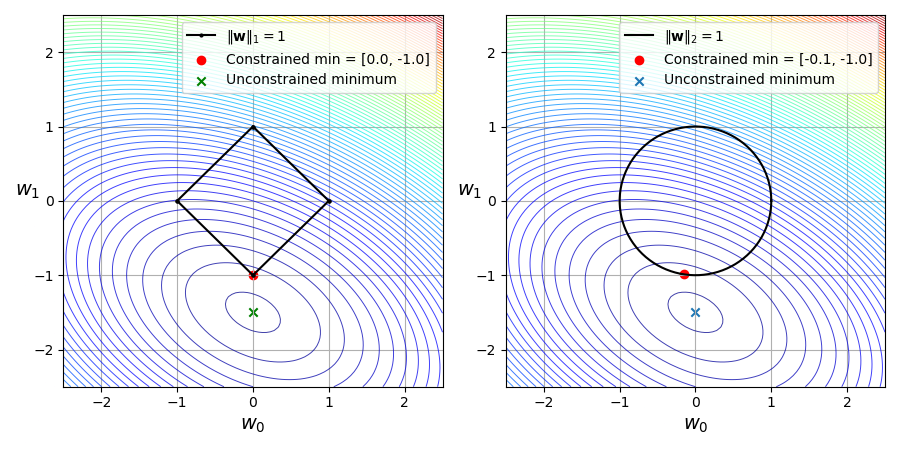

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='$\\Theta$', max=2.0), Float…

In [140]:
#Generate an array of optimal points which we will invoke in the plots

sig1 = 3
sig2 = 4
rho = 0.4

Sigma = np.array([[sig1**2,rho*sig1*sig2],
                 [rho*sig1*sig2,sig2**2]])

# pre-calculate optimisation results
quad_sol = []
quad_l1_sol = []
quad_l2_sol = []
centre_values = []
b_values = []

theta_interact = np.arange(0, 21, 1)/10
r_interact = np.arange(0,4.5,0.25)
rows = np.shape(theta_interact)[0]
cols = np.shape(r_interact)[0]

quad_sol = [[0 for x in range(cols)] for y in range(rows)] 
quad_l1_sol = [[0 for x in range(cols)] for y in range(rows)] 
quad_l2_sol = [[0 for x in range(cols)] for y in range(rows)] 
centre_values = [[0 for x in range(cols)] for y in range(rows)]
b_values = [[0 for x in range(cols)] for y in range(rows)]

for i in theta_interact:
    for j in r_interact:
        
        index_i = int(np.where(theta_interact == i)[0][0])
        index_j = int(np.where(r_interact == j)[0][0])
        # compute x1 and x2
        xc1 = np.sqrt(j)*np.cos(np.pi*i)
        xc2 = np.sqrt(j)*np.sin(np.pi*i)
        
        centre = np.array([xc1,
                           xc2]).reshape(2,1)

        b = -2*np.matmul(Sigma,centre).reshape(2,1)

        centre_values[index_i][index_j] = centre
        b_values[index_i][index_j] = b
        
        f = lambda x : np.matmul(x.T, ( np.matmul(Sigma,x) )) +  np.matmul(b.T, x)
        sol = minimize(f, np.zeros(2))
        quad_sol[index_i][index_j] = sol.x

        from scipy.optimize import NonlinearConstraint

        C1 = NonlinearConstraint(lambda x : np.linalg.norm(x,1), 0, 1)
        l1_sol = minimize(f, np.random.rand(2), constraints=(C1,))
        quad_l1_sol[index_i][index_j] = l1_sol.x


        C2 = NonlinearConstraint(lambda x : np.linalg.norm(x,2), 0, 1)
        l2_sol = minimize(f, np.random.rand(2), constraints=(C2,))
        quad_l2_sol[index_i][index_j] = l2_sol.x
        
        
        
#Generate Plots:
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5))
w0 = np.linspace(-2.5, 2.5, 100)
w1 = np.linspace(-2.5, 2.5, 100)
w0_grid, w1_grid = np.meshgrid(w0, w1)
y_grid = np.zeros([w0.size,w1.size])

def plot_constrain(theta,r):
    index_i = int(np.where(theta_interact == theta)[0][0])
    index_j = int(np.where(r_interact == r)[0][0])

    centre = centre_values[index_i][index_j]
    b = b_values[index_i][index_j]

    #Plot loss surface
    for r in range(0,w0.size):
        for c in range(0, w1.size):
            w_vec = np.array([w0[r],w1[c]]).reshape(2,1)
            A = np.matmul(w_vec.T, ( np.matmul(Sigma,w_vec) ))                  
            B = np.matmul(b.T, w_vec)
            y_grid[c,r] = A + B

    
    #PLOT 1: l1 contrained surface
    ax1.clear()
    ax1.grid()
    ax1.set_xlabel('$w_0$', fontsize=14)
    ax1.set_ylabel('$w_1$', fontsize=14, rotation = 0)

    ax1.contour(w0, w1, y_grid, 100, cmap=plt.cm.jet, linewidths=0.7, alpha=0.75)

    ax1_line1, = ax1.plot([0,1], [1,0], marker='o', markersize=2, color='black',
                          label='$\Vert \mathbf{w} \Vert_1 = 1$')
    ax1_line2, = ax1.plot([1,0], [0,-1], marker='o', markersize=2, color='black')
    ax1_line3, = ax1.plot([0,-1], [-1,0], marker='o', markersize=2, color='black')
    ax1_line4, = ax1.plot([-1,0], [0,1], marker='o', markersize=2, color='black')

    l1_min = '['+str(round(quad_l1_sol[index_i][index_j][0],1))+', '+str(round(quad_l1_sol[index_i][index_j][1],1))+']'
    ax1_con_opt = ax1.scatter(quad_l1_sol[index_i][index_j][0], quad_l1_sol[index_i][index_j][1], color='red', 
                              label='Constrained min = ' + l1_min)
    ax1_unc_opt = ax1.scatter(quad_sol[index_i][index_j][0], quad_sol[index_i][index_j][1], color='green', 
                              label='Unconstrained minimum', marker = 'x')

    ax1.legend()


    #PLOT 2: l2 contrained surface
    ax2.clear()
    ax2.grid()
    ax2.set_xlabel('$w_0$', fontsize=14)
    ax2.set_ylabel('$w_1$', fontsize=14, rotation = 0)

    ax2.contour(w0, w1, y_grid, 100, cmap=plt.cm.jet, linewidths=0.7, alpha=0.75)

    # theta goes from 0 to 2pi
    theta_circle = np.linspace(0, 2*np.pi, 100)
    r_circle = np.sqrt(1)
    # compute x1 and x2
    x1_circle = r_circle*np.cos(theta_circle)
    x2_circle = r_circle*np.sin(theta_circle)
    # create the figure
    ax2.plot(x1_circle, x2_circle, color='black', label='$\Vert \mathbf{w} \Vert_2 = 1$')

    l2_min = '['+str(round(quad_l2_sol[index_i][index_j][0],1))+', '+str(round(quad_l2_sol[index_i][index_j][1],1))+']'
    ax2_con_opt = ax2.scatter(quad_l2_sol[index_i][index_j][0], quad_l2_sol[index_i][index_j][1], color='red',
                              label='Constrained min = ' + l2_min)
    ax2_unc_opt = ax2.scatter(quad_sol[index_i][index_j][0], quad_sol[index_i][index_j][1], 
                              label='Unconstrained minimum', marker = 'x')

    ax2.legend()

int_plot = interact(plot_constrain, 
                    theta = widgets.FloatSlider(description = '$\Theta$', value=0.2, min=0, max=2, step=0.1,continuous_update = False), 
                    r = widgets.FloatSlider(description = '$r^2$', value=1, min=0, max=4, step=0.25,continuous_update = False))


fig.tight_layout()
plt.show()

<div class=question>
<b>Exercise:</b>

Try varying the location of the unconstrained minimium of the quadratic loss surface - you can do this using the $r^2$ and $\theta$ widgets which set the location via circular polar coordinates.

What do you notice about how the constrained solutions compare between the two plots? Does you notice that one seems to spend more time at values of $w_1 =0$ or $w_2 =0$. Why is this?
</div>

<div class=answer>
<b>Answer:</b>

Try $r^2 = 2.25$ and $\theta=1.3, 1.4, 1.5$.

Notice that the shape of the diamond is such that the contours always point away from the isocontours on the ellipses. Meanwhile for the circle the contours tend to intersect with the isocontours of the ellipses. Thus, geometrically, optimal values tend to anchor at vertices. Moreover the number of verices increases as the dimensionality increases so this effect becomes more manifest as the dimension grows.
</div>